
#The implementation of different LSTM models including Encoder-Decoder based approaches for Rainfall-Runoff Modeling for Awash River in Ethiopia.


The data used to model the system are the streamflow, precipitation, temperature, wind speed, and humudity at different guaging stations in the upper Awash river basin. 28 years of daily recorded data is used.

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Import Libraries

In [2]:
import pandas as pd
import datetime as dt  # Python standard library datetime  module
import matplotlib.pyplot as plt
import keras
from pandas import read_csv,concat,DataFrame,datetime
import numpy
import numpy as np
from numpy import concatenate

import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,mean_squared_error,mean_absolute_error

from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, LSTM, GRU, TimeDistributed, Input, RNN,GRUCell,Lambda,Bidirectional,Concatenate,LSTMCell
from tensorflow.keras.models import Sequential,Model
from keras.callbacks import Callback
from tensorflow.keras import backend as K

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.2'

In [ ]:
tf.test.is_gpu_available()    #Tru if Gpu is avalible

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!cat /proc/cpuinfo # Check the processing hardware

# Data preparation and processing

The Path below goes to my mounted GoogleDrive - It should be changed based on your GoogleDrive directory.

In [4]:
path= "/content/drive/MyDrive/1981_final/"

The Datasets were slightly modified before uploading them.

1) Missing data was replaced by taking the average of previous 3 years on similar date of record.

#Stream flow data for 3 stations 1) Berga station 2)Akaki Station 3) Hombole station (this is the target station to predict future streamflow)

In [5]:
sf_berga = pd.read_csv(path + 'berga.csv')
sf_akaki = pd.read_csv(path + 'Akaki.csv')
sf_hom = pd.read_csv(path + 'hombole.csv')

#Precipitation at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [9]:
pcp_aa = pd.read_csv(path + 'pcp_aa.csv') # preciptation at addis ababa station
pcp_hom = pd.read_csv(path + 'pcp_hom.csv') # preciptation at hombole station
pcp_asgori = pd.read_csv(path + 'pcp_asgori.csv') # preciptation at asgori station
pcp_sendefa = pd.read_csv(path + 'pcp_sendefa.csv') # preciptation at sendefa station
pcp_tulubolo = pd.read_csv(path + 'pcp_tulubolo.csv') # preciptation at tulubolo station

pcp_sebeta = pd.read_csv(path + 'pcp_sebeta.csv') # preciptation at sebeta station
pcp_aalem = pd.read_csv(path + 'pcp_aalem.csv') # preciptation at addis alem station
pcp_boneya = pd.read_csv(path + 'pcp_boneya.csv') # preciptation at boneya station
pcp_kimoye = pd.read_csv(path + 'pcp_kimoye.csv') # preciptation at kimoye station
pcp_guranda = pd.read_csv(path + 'pcp_guranda.csv') # preciptation at guranda meta station

pcp_ginchi = pd.read_csv(path + 'pcp_ginchi.csv') # preciptation at ginchi station

#Average of (min and max) temprature at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [10]:
temp_aa = pd.read_csv(path + 'tmp_aa.csv') # temprature at addis ababa station
temp_hom = pd.read_csv(path + 'tmp_hom.csv') # preciptation at hombole station
temp_asgori = pd.read_csv(path + 'tmp_asgori.csv') # preciptation at asgori station
temp_sendefa = pd.read_csv(path + 'tmp_sendefa.csv') # preciptation at sendefa station
temp_tulubolo = pd.read_csv(path + 'tmp_tulubolo.csv') # preciptation at tulubolo station

temp_sebeta = pd.read_csv(path + 'tmp_sebeta.csv') # preciptation at sebeta station
temp_aalem = pd.read_csv(path + 'tmp_aalem.csv') # preciptation at addis alem station
temp_boneya = pd.read_csv(path + 'tmp_boneya.csv') # preciptation at boneya station
temp_kimoye = pd.read_csv(path + 'tmp_kimoye.csv') # preciptation at kimoye station
temp_guranda = pd.read_csv(path + 'tmp_guranda.csv') # preciptation at guranda meta station

temp_ginchi = pd.read_csv(path + 'tmp_ginchi.csv') # preciptation at ginchi station

In [11]:
temp_hom.head()

,DATE,avg_temp
0,1/1/1981,20.20
1,1/2/1981,20.10
2,1/3/1981,20.10
3,1/4/1981,20.15
4,1/5/1981,20.75


#Humudity at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [12]:
hmd_aa = pd.read_csv(path + 'hmd_aa.csv') # humudity at addis ababa station
hmd_hom = pd.read_csv(path + 'hmd_hom.csv') # preciptation at hombole station
hmd_asgori = pd.read_csv(path + 'hmd_asgori.csv') # preciptation at asgori station
hmd_sendefa = pd.read_csv(path + 'hmd_sendefa.csv') # preciptation at sendefa station
hmd_tulubolo = pd.read_csv(path + 'hmd_tulubolo.csv') # preciptation at tulubolo station

hmd_sebeta = pd.read_csv(path + 'hmd_sebeta.csv') # preciptation at sebeta station
hmd_aalem = pd.read_csv(path + 'hmd_aalem.csv') # preciptation at addis alem station
hmd_boneya = pd.read_csv(path + 'hmd_boneya.csv') # preciptation at boneya station
hmd_kimoye = pd.read_csv(path + 'hmd_kimoye.csv') # preciptation at kimoye station
hmd_guranda = pd.read_csv(path + 'hmd_guranda.csv') # preciptation at guranda meta station

hmd_ginchi = pd.read_csv(path + 'hmd_ginchi.csv') # preciptation at ginchi station

#Wind Speed at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [13]:
wnd_aa = pd.read_csv(path + 'wnd_aa.csv') # wind speed at addis ababa station
wnd_hom = pd.read_csv(path + 'wnd_hom.csv') # preciptation at hombole station
wnd_asgori = pd.read_csv(path + 'wnd_asgori.csv') # preciptation at asgori station
wnd_sendefa = pd.read_csv(path + 'wnd_sendefa.csv') # preciptation at sendefa station
wnd_tulubolo = pd.read_csv(path + 'wnd_tulubolo.csv') # preciptation at tulubolo station

wnd_sebeta = pd.read_csv(path + 'wnd_sebeta.csv') # preciptation at sebeta station
wnd_aalem = pd.read_csv(path + 'wnd_aalem.csv') # preciptation at addis alem station
wnd_boneya = pd.read_csv(path + 'wnd_boneya.csv') # preciptation at boneya station
wnd_kimoye = pd.read_csv(path + 'wnd_kimoye.csv') # preciptation at kimoye station
wnd_guranda = pd.read_csv(path + 'wnd_guranda.csv') # preciptation at guranda meta station

wnd_ginchi = pd.read_csv(path + 'wnd_ginchi.csv') # preciptation at ginchi station

#Make date as index

In [14]:
## format datetime column
sf_hom["date"] = pd.to_datetime(sf_hom['date'])
sf_hom = sf_hom.set_index(['date'])
sf_berga["date"] = pd.to_datetime(sf_berga['date'])
sf_berga = sf_berga.set_index(['date'])
sf_akaki["date"] = pd.to_datetime(sf_akaki['date'])
sf_akaki = sf_akaki.set_index(['date'])

## format datetime column
pcp_aa["date"] = pd.to_datetime(pcp_aa['date'])
pcp_aa = pcp_aa.set_index(['date'])
pcp_hom["date"] = pd.to_datetime(pcp_hom['date'])
pcp_hom = pcp_hom.set_index(['date'])
pcp_asgori["date"] = pd.to_datetime(pcp_asgori['date'])
pcp_asgori = pcp_asgori.set_index(['date'])
pcp_sendefa["date"] = pd.to_datetime(pcp_sendefa['date'])
pcp_sendefa = pcp_sendefa.set_index(['date'])
pcp_tulubolo["date"] = pd.to_datetime(pcp_tulubolo['date'])
pcp_tulubolo = pcp_tulubolo.set_index(['date'])
pcp_sebeta["date"] = pd.to_datetime(pcp_sebeta['date'])
pcp_sebeta = pcp_sebeta.set_index(['date'])
pcp_aalem["date"] = pd.to_datetime(pcp_aalem['date'])
pcp_aalem = pcp_aalem.set_index(['date'])
pcp_boneya["date"] = pd.to_datetime(pcp_boneya['date'])
pcp_boneya = pcp_boneya.set_index(['date'])
pcp_kimoye["date"] = pd.to_datetime(pcp_kimoye['date'])
pcp_kimoye = pcp_kimoye.set_index(['date'])
pcp_guranda["date"] = pd.to_datetime(pcp_guranda['date'])
pcp_guranda = pcp_guranda.set_index(['date'])
pcp_ginchi["date"] = pd.to_datetime(pcp_ginchi['date'])
pcp_ginchi = pcp_ginchi.set_index(['date'])
## 
temp_aa["date"] = pd.to_datetime(temp_aa['date'])
temp_aa = temp_aa.set_index(['date'])
temp_hom["DATE"] = pd.to_datetime(temp_hom['DATE'])
temp_hom = temp_hom.set_index(['DATE'])
temp_asgori["date"] = pd.to_datetime(temp_asgori['date'])
temp_asgori = temp_asgori.set_index(['date'])
temp_sendefa["date"] = pd.to_datetime(temp_sendefa['date'])
temp_sendefa = temp_sendefa.set_index(['date'])
temp_tulubolo["date"] = pd.to_datetime(temp_tulubolo['date'])
temp_tulubolo = temp_tulubolo.set_index(['date'])
temp_sebeta["date"] = pd.to_datetime(temp_sebeta['date'])
temp_sebeta = temp_sebeta.set_index(['date'])
temp_aalem["date"] = pd.to_datetime(temp_aalem['date'])
temp_aalem = temp_aalem.set_index(['date'])
temp_boneya["date"] = pd.to_datetime(temp_boneya['date'])
temp_boneya = temp_boneya.set_index(['date'])
temp_kimoye["date"] = pd.to_datetime(temp_kimoye['date'])
temp_kimoye = temp_kimoye.set_index(['date'])
temp_guranda["date"] = pd.to_datetime(temp_guranda['date'])
temp_guranda = temp_guranda.set_index(['date'])
temp_ginchi["date"] = pd.to_datetime(temp_ginchi['date'])
temp_ginchi = temp_ginchi.set_index(['date'])
## 
hmd_aa["date"] = pd.to_datetime(hmd_aa['date'])
hmd_aa = hmd_aa.set_index(['date'])
hmd_hom["date"] = pd.to_datetime(hmd_hom['date'])
hmd_hom = hmd_hom.set_index(['date'])
hmd_asgori["date"] = pd.to_datetime(hmd_asgori['date'])
hmd_asgori = hmd_asgori.set_index(['date'])
hmd_sendefa["date"] = pd.to_datetime(hmd_sendefa['date'])
hmd_sendefa = hmd_sendefa.set_index(['date'])
hmd_tulubolo["date"] = pd.to_datetime(hmd_tulubolo['date'])
hmd_tulubolo = hmd_tulubolo.set_index(['date'])
hmd_sebeta["date"] = pd.to_datetime(hmd_sebeta['date'])
hmd_sebeta = hmd_sebeta.set_index(['date'])
hmd_aalem["date"] = pd.to_datetime(hmd_aalem['date'])
hmd_aalem = hmd_aalem.set_index(['date'])
hmd_boneya["date"] = pd.to_datetime(hmd_boneya['date'])
hmd_boneya = hmd_boneya.set_index(['date'])
hmd_kimoye["date"] = pd.to_datetime(hmd_kimoye['date'])
hmd_kimoye = hmd_kimoye.set_index(['date'])
hmd_guranda["date"] = pd.to_datetime(hmd_guranda['date'])
hmd_guranda = hmd_guranda.set_index(['date'])
hmd_ginchi["date"] = pd.to_datetime(hmd_ginchi['date'])
hmd_ginchi = hmd_ginchi.set_index(['date'])
## 
wnd_aa["date"] = pd.to_datetime(wnd_aa['date'])
wnd_aa = wnd_aa.set_index(['date'])
wnd_hom["date"] = pd.to_datetime(wnd_hom['date'])
wnd_hom = wnd_hom.set_index(['date'])
wnd_asgori["date"] = pd.to_datetime(wnd_asgori['date'])
wnd_asgori = wnd_asgori.set_index(['date'])
wnd_sendefa["date"] = pd.to_datetime(wnd_sendefa['date'])
wnd_sendefa = wnd_sendefa.set_index(['date'])
wnd_tulubolo["date"] = pd.to_datetime(wnd_tulubolo['date'])
wnd_tulubolo = wnd_tulubolo.set_index(['date'])
wnd_sebeta["date"] = pd.to_datetime(wnd_sebeta['date'])
wnd_sebeta = wnd_sebeta.set_index(['date'])
wnd_aalem["date"] = pd.to_datetime(wnd_aalem['date'])
wnd_aalem = wnd_aalem.set_index(['date'])
wnd_boneya["date"] = pd.to_datetime(wnd_boneya['date'])
wnd_boneya = wnd_boneya.set_index(['date'])
wnd_kimoye["date"] = pd.to_datetime(wnd_kimoye['date'])
wnd_kimoye = wnd_kimoye.set_index(['date'])
wnd_guranda["date"] = pd.to_datetime(wnd_guranda['date'])
wnd_guranda = wnd_guranda.set_index(['date'])
wnd_ginchi["date"] = pd.to_datetime(wnd_ginchi['date'])
wnd_ginchi = wnd_ginchi.set_index(['date'])

#Convert to floating point values 

In [15]:
sf_hom['streamflow']=sf_hom['streamflow'].astype(float)
sf_akaki['streamflow']=sf_akaki['streamflow'].astype(float)
sf_berga['streamflow']=sf_berga['streamflow'].astype(float)

pcp_aa['PCP']=pcp_aa['PCP'].astype(float)
pcp_hom['PCP']=pcp_hom['PCP'].astype(float)
pcp_asgori['PCP']=pcp_asgori['PCP'].astype(float)
pcp_sendefa['PCP']=pcp_sendefa['PCP'].astype(float)
pcp_tulubolo['PCP']=pcp_tulubolo['PCP'].astype(float)
pcp_sebeta['PCP']=pcp_sebeta['PCP'].astype(float)
pcp_aalem['PCP']=pcp_aalem['PCP'].astype(float)
pcp_boneya['PCP']=pcp_boneya['PCP'].astype(float)
pcp_kimoye['PCP']=pcp_kimoye['PCP'].astype(float)
pcp_guranda['PCP']=pcp_guranda['PCP'].astype(float)
pcp_ginchi['PCP']=pcp_ginchi['PCP'].astype(float)


temp_aa['avg_temp']=temp_aa['avg_temp'].astype(float)
temp_hom['avg_temp']=temp_hom['avg_temp'].astype(float)
temp_asgori['avg_temp']=temp_asgori['avg_temp'].astype(float)
temp_sendefa['avg_temp']=temp_sendefa['avg_temp'].astype(float)
temp_tulubolo['avg_temp']=temp_tulubolo['avg_temp'].astype(float)
temp_sebeta['avg_temp']=temp_sebeta['avg_temp'].astype(float)
temp_aalem['avg_temp']=temp_aalem['avg_temp'].astype(float)
temp_boneya['avg_temp']=temp_boneya['avg_temp'].astype(float)
temp_kimoye['avg_temp']=temp_kimoye['avg_temp'].astype(float)
temp_guranda['avg_temp']=temp_guranda['avg_temp'].astype(float)
temp_ginchi['avg_temp']=temp_ginchi['avg_temp'].astype(float)


hmd_aa['HMD']=hmd_aa['HMD'].astype(float)
hmd_hom['HMD']=hmd_hom['HMD'].astype(float)
hmd_asgori['HMD']=hmd_asgori['HMD'].astype(float)
hmd_sendefa['HMD']=hmd_sendefa['HMD'].astype(float)
hmd_tulubolo['HMD']=hmd_tulubolo['HMD'].astype(float)
hmd_sebeta['HMD']=hmd_sebeta['HMD'].astype(float)
hmd_aalem['HMD']=hmd_aalem['HMD'].astype(float)
hmd_boneya['HMD']=hmd_boneya['HMD'].astype(float)
hmd_kimoye['HMD']=hmd_kimoye['HMD'].astype(float)
hmd_guranda['HMD']=hmd_guranda['HMD'].astype(float)
hmd_ginchi['HMD']=hmd_ginchi['HMD'].astype(float)

wnd_aa['WND']=wnd_aa['WND'].astype(float)
wnd_hom['WND']=wnd_hom['WND'].astype(float)
wnd_asgori['WND']=wnd_asgori['WND'].astype(float)
wnd_sendefa['WND']=wnd_sendefa['WND'].astype(float)
wnd_tulubolo['WND']=wnd_tulubolo['WND'].astype(float)
wnd_sebeta['WND']=wnd_sebeta['WND'].astype(float)
wnd_aalem['WND']=wnd_aalem['WND'].astype(float)
wnd_boneya['WND']=wnd_boneya['WND'].astype(float)
wnd_kimoye['WND']=wnd_kimoye['WND'].astype(float)
wnd_guranda['WND']=wnd_guranda['WND'].astype(float)
wnd_ginchi['WND']=wnd_ginchi['WND'].astype(float)



#Stream flow plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc5f8ba89d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5f9937450>)

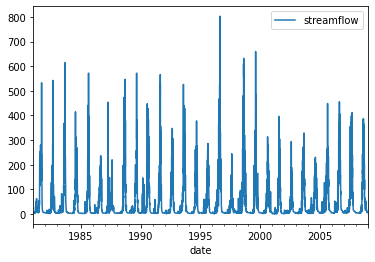

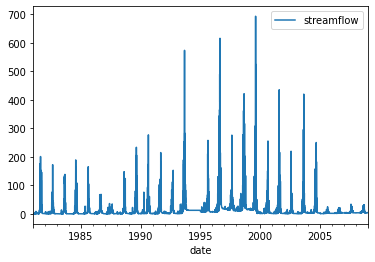

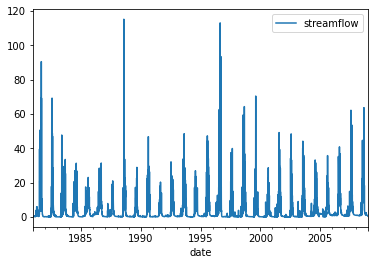

In [ ]:
sf_hom.plot(), sf_akaki.plot(), sf_berga.plot()

#Precipitation plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc5f9577610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5f85a89d0>)

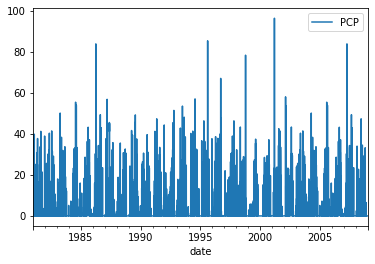

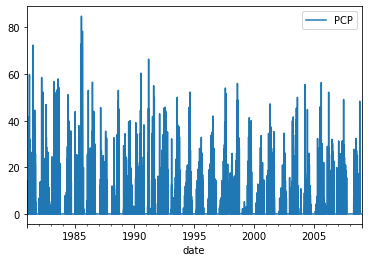

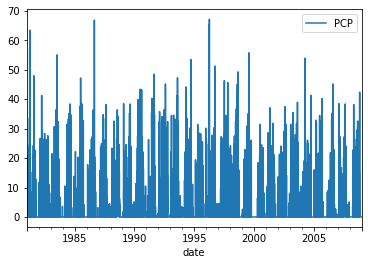

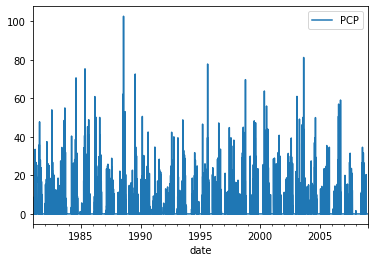

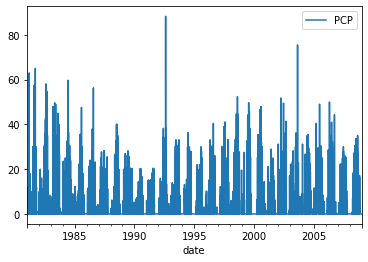

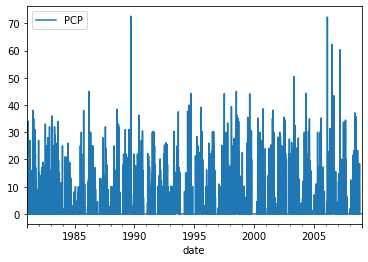

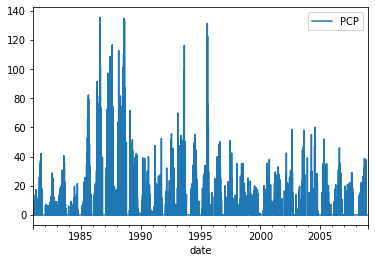

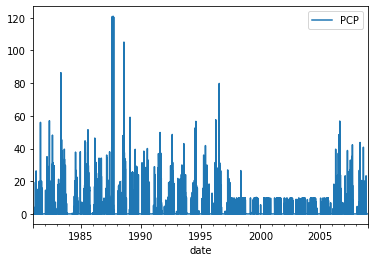

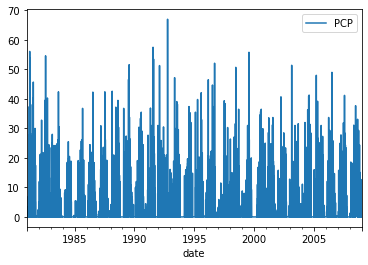

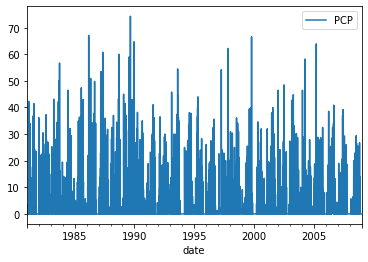

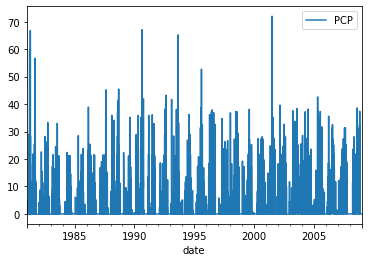

In [ ]:
pcp_aa.plot(), pcp_hom.plot(),pcp_asgori.plot(),pcp_sendefa.plot(),pcp_tulubolo.plot(),pcp_aalem.plot(), pcp_sebeta.plot(),pcp_boneya.plot(),pcp_kimoye.plot(),pcp_ginchi.plot(),pcp_guranda.plot()

#Tempature Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc5f9108950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5f679e6d0>)

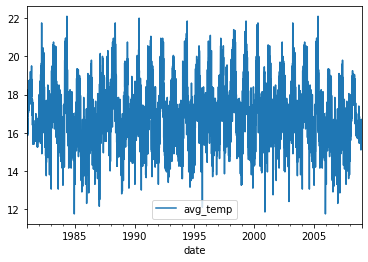

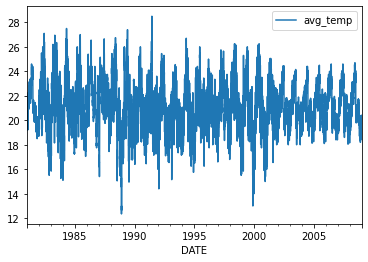

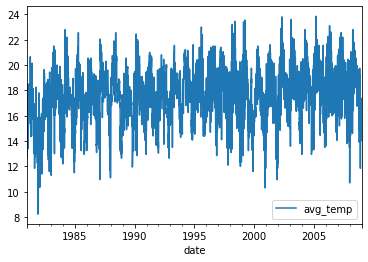

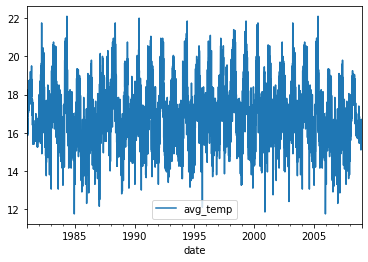

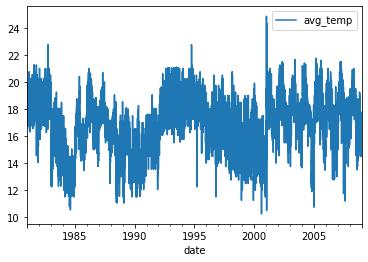

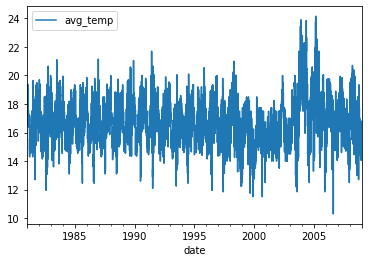

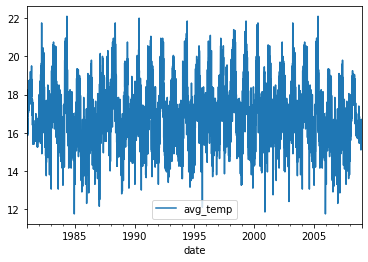

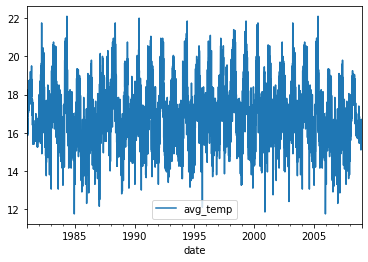

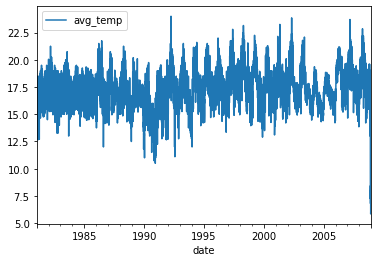

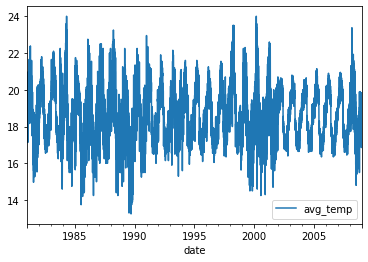

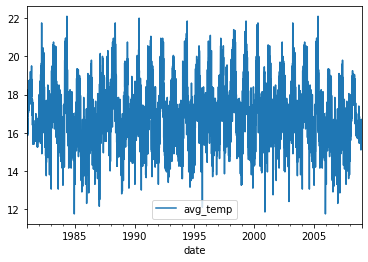

In [ ]:
temp_aa.plot(), temp_hom.plot(),temp_asgori.plot(),temp_sendefa.plot(),temp_tulubolo.plot(),temp_aalem.plot(), temp_sebeta.plot(),temp_boneya.plot(),temp_kimoye.plot(),temp_ginchi.plot(),temp_guranda.plot()

#Humudity Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc5f6453090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5f52bd950>)

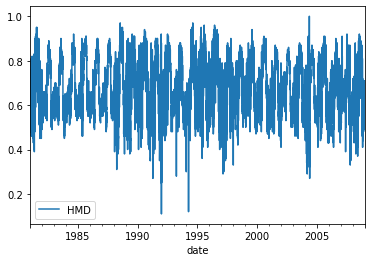

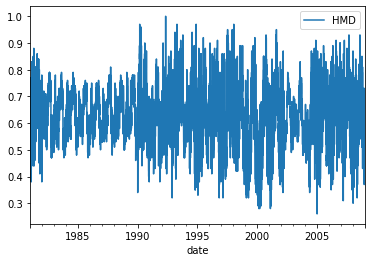

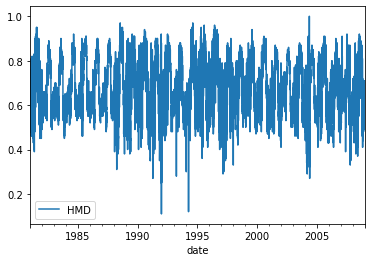

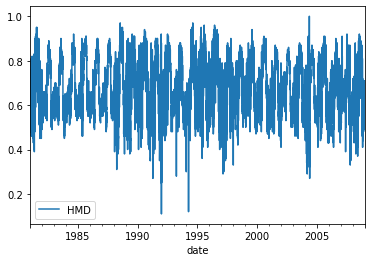

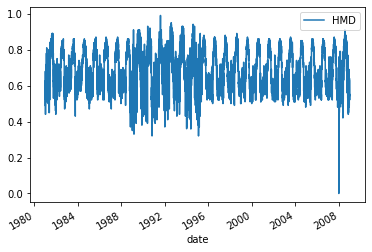

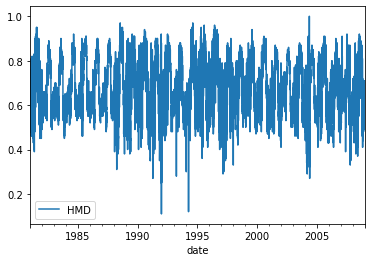

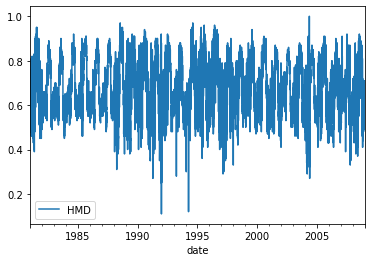

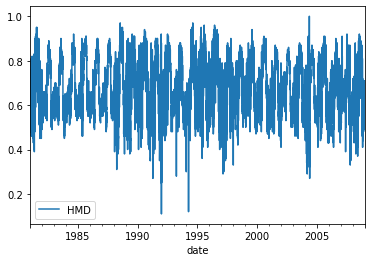

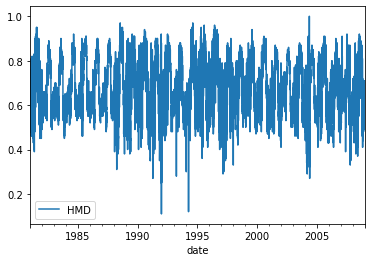

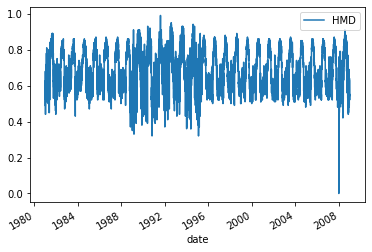

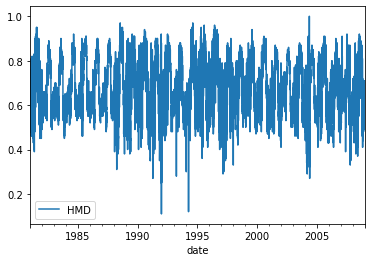

In [ ]:
hmd_aa.plot(), hmd_hom.plot(),hmd_asgori.plot(),hmd_sendefa.plot(),hmd_tulubolo.plot(),hmd_aalem.plot(), hmd_sebeta.plot(),hmd_boneya.plot(),hmd_kimoye.plot(),hmd_ginchi.plot(),hmd_guranda.plot()

#wind plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc5f4f16810>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5f4f052d0>)

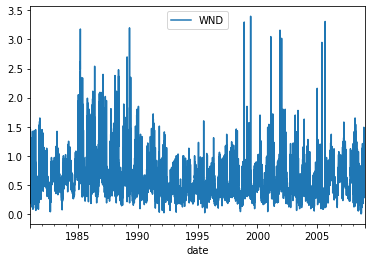

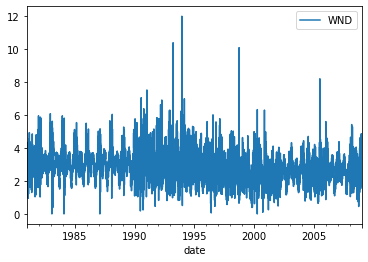

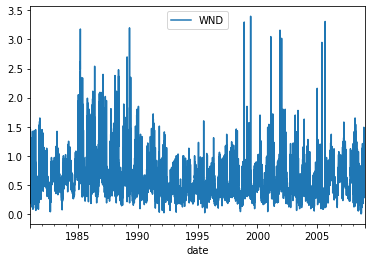

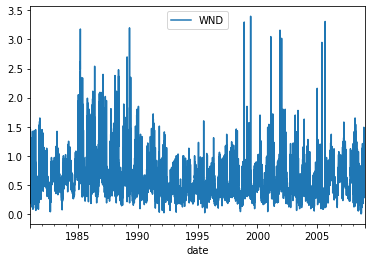

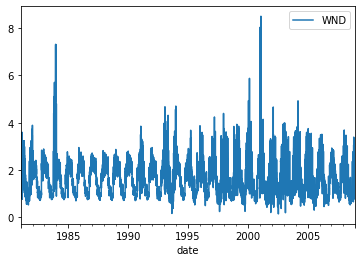

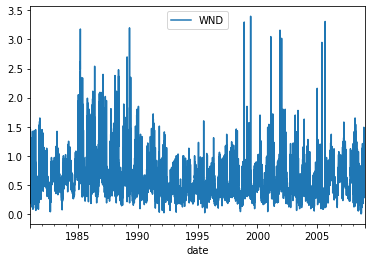

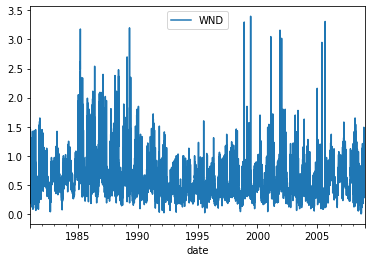

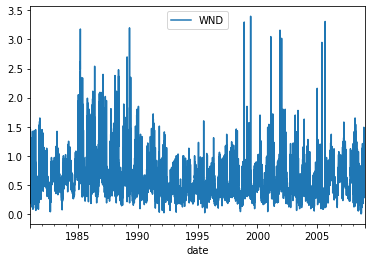

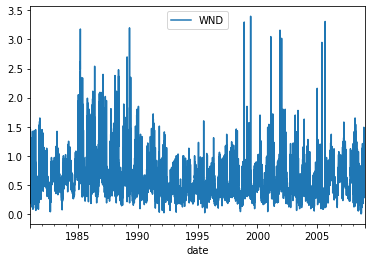

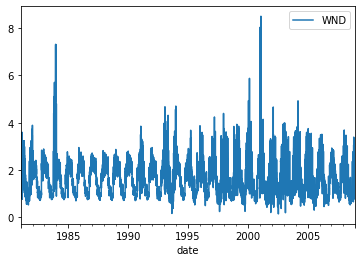

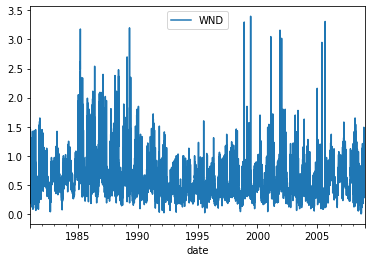

In [ ]:
wnd_aa.plot(),wnd_hom.plot(),wnd_asgori.plot(),wnd_sendefa.plot(),wnd_tulubolo.plot(),wnd_aalem.plot(), wnd_sebeta.plot(),wnd_boneya.plot(),wnd_kimoye.plot(),wnd_ginchi.plot(),wnd_guranda.plot()



#Resampled daily, weekly, monthly and yearly mean value for streamflow at target station

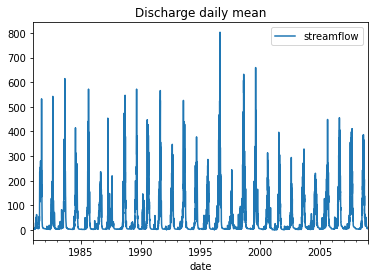

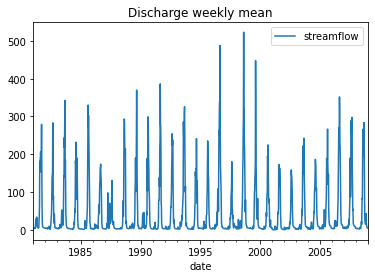

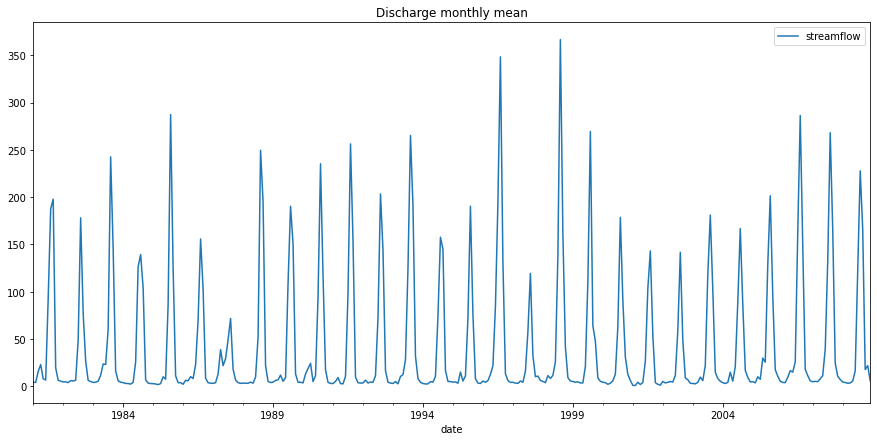

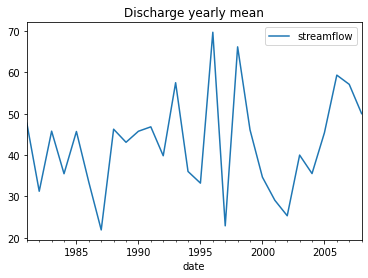

In [ ]:
sf_hom_D = sf_hom.resample('1D').mean()
sf_hom_W = sf_hom.resample('1W').mean()
sf_hom_M = sf_hom.resample('1M').mean()
sf_hom_Y = sf_hom.resample('1Y').mean()


sf_hom_D.plot(title="Discharge daily mean")
sf_hom_W.plot(title="Discharge weekly mean")
sf_hom_M.plot(title="Discharge monthly mean",figsize=(15,7))
sf_hom_Y.plot(title="Discharge yearly mean")

#Autocorrelation for streamflow at 3 different guaging stations

In [ ]:
pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax= pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax.set_xlim([0, 2000])
plt.title("Discharge daily mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_akaki['streamflow'])
plt.title("Discharge weekly mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_berga['streamflow'])
plt.title("Discharge monthly mean")
plt.show()

#from the graphs we can see that there is a corellation between the streamflows and their lags. But after 2000 days the correlation starts to decrease.
# The negative correlation between the time lags is mostly insignificant. This may be due to seasonality of the streamflow---meaning that in one
#season the streamflow may be high and on the next season it will be less 
# The plot also shows seasonality of the data 

In [ ]:
print(len(sf_akaki['streamflow']))
plot_acf(sf_akaki['streamflow'],lags=50)

plot_acf(sf_hom['streamflow'],lags=50)

plot_acf(sf_berga['streamflow'],lags=50)

#Autocorrelation for preciptation at 11 guaging stations 

In [ ]:
#pd.plotting.autocorrelation_plot(pcp_aa['PCP'])
plot_acf(pcp_aa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_hom['PCP'])
plot_acf(pcp_hom['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_asgori['PCP'])
plot_acf(pcp_asgori['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sendefa['PCP'])
plot_acf(pcp_sendefa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_tulubolo['PCP'])
plot_acf(pcp_tulubolo['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_aalem['PCP'])
plot_acf(pcp_aalem['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_boneya['PCP'])
plot_acf(pcp_boneya['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_kimoye['PCP'])
plot_acf(pcp_kimoye['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sebeta['PCP'])
plot_acf(pcp_sebeta['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_guranda['PCP'])
plot_acf(pcp_guranda['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_ginchi['PCP'])
plot_acf(pcp_ginchi['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#Autocorrelation for temperature at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
# plt.title("Temperature daily")
# plt.show()

#pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
plot_acf(temp_aa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_hom['avg_temp'])
plot_acf(temp_hom['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_asgori['avg_temp'])
plot_acf(temp_asgori['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sendefa['avg_temp'])
plot_acf(temp_sendefa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_tulubolo['avg_temp'])
plot_acf(temp_tulubolo['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_aalem['avg_temp'])
plot_acf(temp_aalem['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_boneya['avg_temp'])
plot_acf(temp_boneya['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_kimoye['avg_temp'])
plot_acf(temp_kimoye['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sebeta['avg_temp'])
plot_acf(temp_sebeta['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_guranda['avg_temp'])
plot_acf(temp_guranda['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_ginchi['avg_temp'])
plot_acf(temp_ginchi['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()


#Autocorrelation for Humudity at 11 guaging stations

In [ ]:
pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=100)
plt.title("humidity daily")
plt.show()

In [ ]:
#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#the jumidity at ginchi station does not have any corelation and it is removed from our dataset since it will not help on prediction task.

In [ ]:
# pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
# plt.title("humudirt daily")
# plt.show()

#pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
plot_acf(hmd_aa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_hom['HMD'])
plot_acf(hmd_hom['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_asgori['HMD'])
plot_acf(hmd_asgori['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sendefa['HMD'])
plot_acf(hmd_sendefa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_aalem['HMD'])
plot_acf(hmd_aalem['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_boneya['HMD'])
plot_acf(hmd_boneya['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_kimoye['HMD'])
plot_acf(hmd_kimoye['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sebeta['HMD'])
plot_acf(hmd_sebeta['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_guranda['HMD'])
plot_acf(hmd_guranda['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()


#Autocorrelation for wind at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(wnd_aa['WND'])
# plt.title("wind daily")
# plt.show()

#pd.plotting.autocorrelation_plot(wnd_aa['WND'])
plot_acf(wnd_aa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_hom['WND'])
plot_acf(wnd_hom['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_asgori['WND'])
plot_acf(wnd_asgori['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sendefa['WND'])
plot_acf(wnd_sendefa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_tulubolo['WND'])
plot_acf(wnd_tulubolo['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_aalem['WND'])
plot_acf(wnd_aalem['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_boneya['WND'])
plot_acf(wnd_boneya['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_kimoye['WND'])
plot_acf(wnd_kimoye['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sebeta['WND'])
plot_acf(wnd_sebeta['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_guranda['WND'])
plot_acf(wnd_guranda['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_ginchi['WND'])
plot_acf(wnd_ginchi['WND'],lags=50)
plt.title("wind daily")
plt.show()


#Data Preparation for univariate input(i.e preciptation,temp,hum,wind @ 11 guaging stations and lagged discharge @ 3 guaging stations) and multiple step output (streamflow at target guaging station for future n days) Encoder-Decoder MODEL

#Supervised data generating function

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
# n stations [prcn, prcn-1,...prc1]

#variable declaration

In [18]:
look_back = 10 #Number of time-steps/ time-lags to see before predicting the current 
n_features = 1 # discharge @ target station which is hombole

#Variable declaration

In [19]:
n_hours = look_back

#1. Training data preparation on year based slicing of pandas dataframe into trainig, validation and test, 20 years data used for training , 4 years data for validation and 4 years data for testing

#Dataframe holding univariate training data

In [20]:
raw = DataFrame()
#Temperature features 
# raw['temp_aa'] = temp_aa['avg_temp']
# raw['temp_hom'] = temp_hom['avg_temp']
# raw['temp_mojo'] = temp_mojo['avg_temp']
# raw['temp_sendefa'] = temp_sendefa['avg_temp']
# raw['temp_tulubolo'] = temp_tulubolo['avg_temp']
# #preciptation features
# raw['rain_aa'] = pcp_aa['PCP']
# raw['rain_hom'] = pcp_hom['PCP']
# raw['rain_mojo'] = pcp_mojo['PCP']
# raw['rain_sendefa'] = pcp_sendefa['PCP']
# raw['rain_tulubolo'] = pcp_tulubolo['PCP']
# #Humudity features 
# raw['hmd_aa'] = hmd_aa['HMD']
# raw['hmd_hom'] = hmd_hom['HMD']
# raw['hmd_mojo'] = hmd_mojo['HMD']
# raw['hmd_sendefa'] = hmd_sendefa['HMD']
# raw['hmd_tulubolo'] = hmd_tulubolo['HMD']
# #Wind features 
# raw['wnd_aa'] = wnd_aa['WND']
# raw['wnd_hom'] = wnd_hom['WND']
# raw['wnd_mojo'] = wnd_mojo['WND']
# raw['wnd_sendefa'] = wnd_sendefa['WND']
# raw['wnd_tulubolo'] = wnd_tulubolo['WND']

#Streamflow features
# raw['Q_akaki'] = sf_akaki['streamflow']
# raw['Q_mojo'] = sf_mojo['streamflow']
raw['Q_hom'] = sf_hom['streamflow']

values2 = raw.values  

#Training data partition (1981 - 2000)

In [21]:
raw_train= raw.loc['1981-01-01':'2000-12-31']
values_train = raw_train.values

#Validation data partition (2001 - 2004)

In [22]:
raw_val = raw.loc['2001-01-01':'2004-12-31']
values_val = raw_val.values


#Test data partition (2004 - 2008)

In [23]:
raw_test = raw.loc['2005-01-01':'2008-12-31']
values_test = raw_test.values

#Generating Supervised data for train, valid and test

In [24]:
sup_train = series_to_supervised(values_train, n_hours, 3) 

print(sup_train.shape)

(7293, 13)


In [25]:
sup_val = series_to_supervised(values_val, n_hours, 3) 

print(sup_val.shape)

(1449, 13)


In [26]:
sup_test = series_to_supervised(values_test, n_hours, 3) 

print(sup_test.shape)

(1449, 13)


#Train, validation and Test split

In [27]:
train = sup_train.values
val = sup_val.values
test = sup_test.values

In [28]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, [10,11,12]]
test_X, test_y = test[:, :n_obs], test[:, [10,11,12]]
val_X, val_y = val[:, :n_obs], val[:, [10,11,12]]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(7293, 10) 7293 (7293, 3)
(1449, 10) 1449 (1449, 3)
(1449, 10) 1449 (1449, 3)


#2. Training data prepartion by randomly classifying the whole data into train, validation and test

##Dataframe holding univariate training data

In [ ]:
raw = DataFrame()
#Temperature features 
# raw['temp_aa'] = temp_aa['avg_temp']
# raw['temp_hom'] = temp_hom['avg_temp']
# raw['temp_mojo'] = temp_mojo['avg_temp']
# raw['temp_sendefa'] = temp_sendefa['avg_temp']
# raw['temp_tulubolo'] = temp_tulubolo['avg_temp']
# #preciptation features
# raw['rain_aa'] = pcp_aa['PCP']
# raw['rain_hom'] = pcp_hom['PCP']
# raw['rain_mojo'] = pcp_mojo['PCP']
# raw['rain_sendefa'] = pcp_sendefa['PCP']
# raw['rain_tulubolo'] = pcp_tulubolo['PCP']
# #Humudity features 
# raw['hmd_aa'] = hmd_aa['HMD']
# raw['hmd_hom'] = hmd_hom['HMD']
# raw['hmd_mojo'] = hmd_mojo['HMD']
# raw['hmd_sendefa'] = hmd_sendefa['HMD']
# raw['hmd_tulubolo'] = hmd_tulubolo['HMD']
# #Wind features 
# raw['wnd_aa'] = wnd_aa['WND']
# raw['wnd_hom'] = wnd_hom['WND']
# raw['wnd_mojo'] = wnd_mojo['WND']
# raw['wnd_sendefa'] = wnd_sendefa['WND']
# raw['wnd_tulubolo'] = wnd_tulubolo['WND']

#Streamflow features
# raw['Q_akaki'] = sf_akaki['streamflow']
# raw['Q_mojo'] = sf_mojo['streamflow']
raw['Q_hom'] = sf_hom['streamflow']

values2 = raw.values  

#Data frame after data is converted to supervised format for univariate input and multi-step output setup

In [ ]:
reframed = series_to_supervised(values2, n_hours, 3) 

print(reframed.shape)

(10215, 13)


In [ ]:
reframed

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
10,4.238,4.238,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121
11,4.238,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121
12,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121
13,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121
14,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10220,5.717,5.585,5.455,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074
10221,5.585,5.455,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074
10222,5.455,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074,5.074
10223,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074,5.074,5.074


#Train, validation and Test split

In [ ]:
values_2 = reframed.values
TRAIN_SIZE = 0.8
n_train = int(len(values_2) * TRAIN_SIZE) 
train = values_2[:n_train, :]
eval = values_2[n_train:, :]

In [ ]:
TEST_SIZE = 0.5
n_val= int(len(eval) * TEST_SIZE) 
val = eval[:n_val, :]
test = eval[n_val:, :]

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, [10,11,12]]
test_X, test_y = test[:, :n_obs], test[:, [10,11,12]]
val_X, val_y = val[:, :n_obs], val[:, [10,11,12]]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(8172, 10) 8172 (8172, 3)
(1022, 10) 1022 (1022, 3)
(1021, 10) 1021 (1021, 3)


#Feature scaling (the next part of code will work for both approaches described above as 1) and 2) )

In [29]:
# feature scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(train_X)

scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_train = scaler_Y.fit_transform(train_y)

In [30]:
X_test = scaler_X.transform(test_X)
Y_test = scaler_Y.transform(test_y)

X_val = scaler_X.transform(val_X)
Y_val = scaler_Y.transform(val_y)

#Reshaping train, validation and test data into 3D shape since LSTM takes as input a data in the format (samples, time-step, sample_features)

In [31]:
train_X2 = X_train.reshape((X_train.shape[0], n_hours, n_features))
test_X2 = X_test.reshape((X_test.shape[0], n_hours, n_features))
val_X2 = X_val.reshape((X_val.shape[0], n_hours, n_features))
print(train_X2.shape, train_y.shape, test_X2.shape, test_y.shape,val_X2.shape, val_y.shape)

(7293, 10, 1) (7293, 3) (1449, 10, 1) (1449, 3) (1449, 10, 1) (1449, 3)


#Here the target value shape is also changed in to 3D shape to make it suitable for Encoder-Decoder model design.

In [32]:
train_y2 = Y_train.reshape((Y_train.shape[0], 3, 1))
test_y2 = Y_test.reshape((Y_test.shape[0], 3, 1))
val_y2 = Y_val.reshape((Y_val.shape[0], 3, 1))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape,val_X2.shape, val_y2.shape)

(7293, 10, 1) (7293, 3, 1) (1449, 10, 1) (1449, 3, 1) (1449, 10, 1) (1449, 3, 1)


#Training data preparation for teacher forcing encoder-decoder training. In this approach the ground truth y_label is shifted by 1. In the shifted location we used a START TOKEN. In machine translation problems the most commonly used start tokens are SOS and EOS tags but since we are working on time series numeric data we should have to use numeric values. But the value we use as start token should not be part of the training data. Therefore I selcted other numeric values as start token for this problem.

In [30]:
train_decoder_input_data= Y_train.tolist()
for row in train_decoder_input_data:
    row.insert(0,0)
for row in train_decoder_input_data:
    row.pop()
train_decoder_input_data = np.array(train_decoder_input_data)

In [31]:
val_decoder_input_data = Y_val.tolist()
for row in val_decoder_input_data:
    row.insert(0,0)
for row in val_decoder_input_data:
    row.pop()
val_decoder_input_data = np.array(val_decoder_input_data)

In [32]:
test_decoder_input_data = Y_test.tolist()
for row in test_decoder_input_data:
    row.insert(0,0)
for row in test_decoder_input_data:
    row.pop()
test_decoder_input_data = np.array(test_decoder_input_data)

In [33]:
train_decoder_input_data = train_decoder_input_data.reshape((train_y2.shape[0], 3, 1))
test_decoder_input_data = test_decoder_input_data.reshape((test_y2.shape[0], 3, 1))
val_decoder_input_data = val_decoder_input_data.reshape((val_y2.shape[0], 3, 1))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape,test_decoder_input_data.shape,train_decoder_input_data.shape)

(7293, 10, 1) (7293, 3, 1) (1449, 10, 1) (1449, 3, 1) (1449, 3, 1) (7293, 3, 1)


#In previous section I have used zero as START TOKEN of the decoder input. But zero is part of the training dataset and that is not a correct way to select a START TOKEN since zero is part of the training data. Thus in this part I have used -1 as START TOKEN and see the differnce in prediction accuracy of the teacher forcing based Encoder-Decoder Approach.

In [67]:
train_decoder_input_data= Y_train.tolist()
for row in train_decoder_input_data:
    row.insert(0,-1)
for row in train_decoder_input_data:
    row.pop()
train_decoder_input_data = np.array(train_decoder_input_data)

In [68]:
val_decoder_input_data = Y_val.tolist()
for row in val_decoder_input_data:
    row.insert(0,-1)
for row in val_decoder_input_data:
    row.pop()
val_decoder_input_data = np.array(val_decoder_input_data)

In [69]:
test_decoder_input_data = Y_test.tolist()
for row in test_decoder_input_data:
    row.insert(0,-1)
for row in test_decoder_input_data:
    row.pop()
test_decoder_input_data = np.array(test_decoder_input_data)

In [70]:
train_decoder_input_data = train_decoder_input_data.reshape((Y_train.shape[0], 3, 1))
val_decoder_input_data = val_decoder_input_data.reshape((Y_val.shape[0], 3, 1))
test_decoder_input_data = test_decoder_input_data.reshape((Y_test.shape[0], 3, 1))
print(test_decoder_input_data.shape,train_decoder_input_data.shape,val_decoder_input_data.shape)

(1449, 3, 1) (7293, 3, 1) (1449, 3, 1)


#1. Teacher forcing based Encoder-Decoder approach model setup.

In [33]:
keras.backend.clear_session()

layers = [100, 100] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.001
decay = 0 # Learning rate decay
optimiser = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. 
num_output_features = 1 # The dimensionality of the output at each time step. 

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 10 # Length of the sequence used by the encoder
target_sequence_length = 1 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#In the folowwing cells single layer LSTM and GRU are used both at the Encoder and Decoder.

In [221]:
LSTMoutputDimension = 50

In [229]:
encoder_inputs= Input(shape=(input_sequence_length, num_input_features))
encoder_lstm=LSTM(LSTMoutputDimension, return_state=True)
encoder_lstm=GRU(LSTMoutputDimension, return_state=True)
# LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
LSTM_outputs, state_h = encoder_lstm(encoder_inputs)

#encoder_states = [state_h,state_c]
encoder_states = [state_h]

decoder_inputs = Input(shape=(None, num_output_features), name='decoder_inputs')
#decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_lstm = GRU(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

#decoder_outputs, _,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # For the case of LSTM based architecture we have 3 outputs
decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # For the case of GRU based architecture we have 2 outputs

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = Dense(num_output_features, activation='linear', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)



model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

In [230]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#model_encoder_training.summary()

In [ ]:
history2 = model.fit([train_X2,train_decoder_input_data], train_y2, epochs=50, batch_size=100, validation_data=([val_X2,val_decoder_input_data], val_y2), verbose=1, shuffle=False)

#In the following cells Stacked (2 layer)  LSTM/GRU architectures are used both at the Encoder and Decoder. Here the input is using the teacher forcing approach as explained above.

In [52]:
# The Encoder
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    # Stacked LSTM
    # encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))
    

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

encoder_states = encoder_outputs_and_states[1:]

In [53]:
# The decoder 
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    #Stacked LSTM
    # decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

decoder_outputs = decoder_outputs_and_states[0]

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

#In the following cells single and 2 layer layer Bi-LSTM/GRU architectures are used both at the Encoder and Decoder. Here also the input is using the teacher forcing approach as explained above. ( It does not work well for the task. May be due to the teacher forcing approach is not suitable for forward backward computation of gradients)

In [71]:
# The encoder
encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

#encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
encoder_lstm1 = Bidirectional(GRU(50,return_state=True,return_sequences=True))
#encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

#encoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
encoder_lstm2 = Bidirectional(GRU(50,return_state=True))
#encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)

# state_h = Concatenate()([forward_h2,backward_h2])
# state_c = Concatenate()([forward_c2,backward_c2])
#encoder_states = [state_h, state_c]

#states = [forward_h2,forward_c2,backward_h2,backward_c2]
states = [forward_h2,backward_h2]



#The Decoder part 
decoder_inputs = keras.layers.Input(shape=(None, 1))


#decoder_lstm1 = Bidirectional(LSTM(50,return_state=True,return_sequences=True))
decoder_lstm1 = Bidirectional(GRU(50,return_state=True,return_sequences=True))
#decoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = decoder_lstm1(decoder_inputs,initial_state=states)
decoder_lstm1_output,forward_h1,backward_h1 = decoder_lstm1(decoder_inputs,initial_state=states)

#decoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
#decoder_lstm2 = Bidirectional(GRU(50,return_state=True))
#decoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = decoder_lstm2(decoder_lstm1_output)
#decoder_lstm2_output,forward_h2,backward_h2 = decoder_lstm2(decoder_lstm1_output)

decoder_outputs = decoder_lstm1_output

dropout = Dropout(rate=0.25)
decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                  activation='linear',
                                  kernel_regularizer=regulariser,
                                  bias_regularizer=regulariser)


decoder_outputs = decoder_dense(decoder_outputs)


#Training the Model

In [ ]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.summary()
model.compile(optimizer=optimiser, loss=loss)

In [ ]:
history2 = model.fit([train_X2,train_decoder_input_data], train_y2, epochs=50, batch_size=100, validation_data=([val_X2,val_decoder_input_data], val_y2), verbose=1, shuffle=False)

#Plotting the loss curve

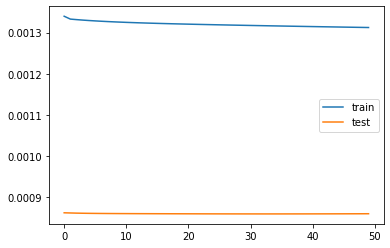

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction on test set data

In [74]:
y_test_predicted = model.predict([test_X2,test_decoder_input_data])
pred= tf.reshape(y_test_predicted, [1449, 3])
orig=tf.reshape(test_y2, [1449, 3])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#A function used to calculate the mean squared error, MAE and NSE value of a given model for the multi-step prediction encoder-decoder approach.

In [41]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_mse(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2

	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [42]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_mae(actual, predicted):
	scores2 = list()
	# calculate an MAE score for each day
	for i in range(actual.shape[1]):
		# calculate mae
		mae = mean_absolute_error(actual[:, i], predicted[:, i])
		mae = sqrt(mae)**2
		# store
		scores2.append(mae)
	# calculate overall MAE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += abs(actual[row, col] - predicted[row, col])
			s= sqrt(s)**2
	score2 = s / (actual.shape[0] * actual.shape[1])
	return score2, scores2

In [43]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_nse(actual, predicted):
  scores = list()
  # calculate an NSE score for each day
  for i in range(actual.shape[1]):
    nse = 1-(np.sum(np.power((actual[:, i]-predicted[:, i]),2))/np.sum(np.power((actual[:, i]-actual[:, i].mean()),2)))
    # store
    nse= sqrt(nse)**2
    scores.append(nse)
  # calculate overall NSE
  s1 = 0
  s2= 0
  m= (actual[:, 0].mean() + actual[:, 1].mean() + actual[:, 1].mean()) / 3
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s1 += np.power((actual[row, col]-predicted[row, col]),2)
      s2 += np.power((actual[row, col]- m),2)
      s1= sqrt(s1)**2
      s2 = sqrt(s2)**2

  score = 1- (s1/s2)
  return score, scores

#RMSE, MAE and NSE score values for individual days and the cummulative value for (t+n) prediciton days

In [47]:
%precision %.2f

'%.2f'

In [77]:
score, scores = evaluate_forecasts_mse(inv_y2, inv_yhat2)
score, scores

(16.87, [3.79, 5.35, 28.47])

In [143]:
score, scores = evaluate_forecasts_mae(inv_y2, inv_yhat2)
score, scores

(12.40, [12.65, 12.31, 12.23])

In [144]:
score, scores = evaluate_forecasts_nse(inv_y2, inv_yhat2)
score, scores

(0.90, [0.90, 0.90, 0.90])

#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.706  versus inv_yhat2 (SIM) max: 396.94615937143567


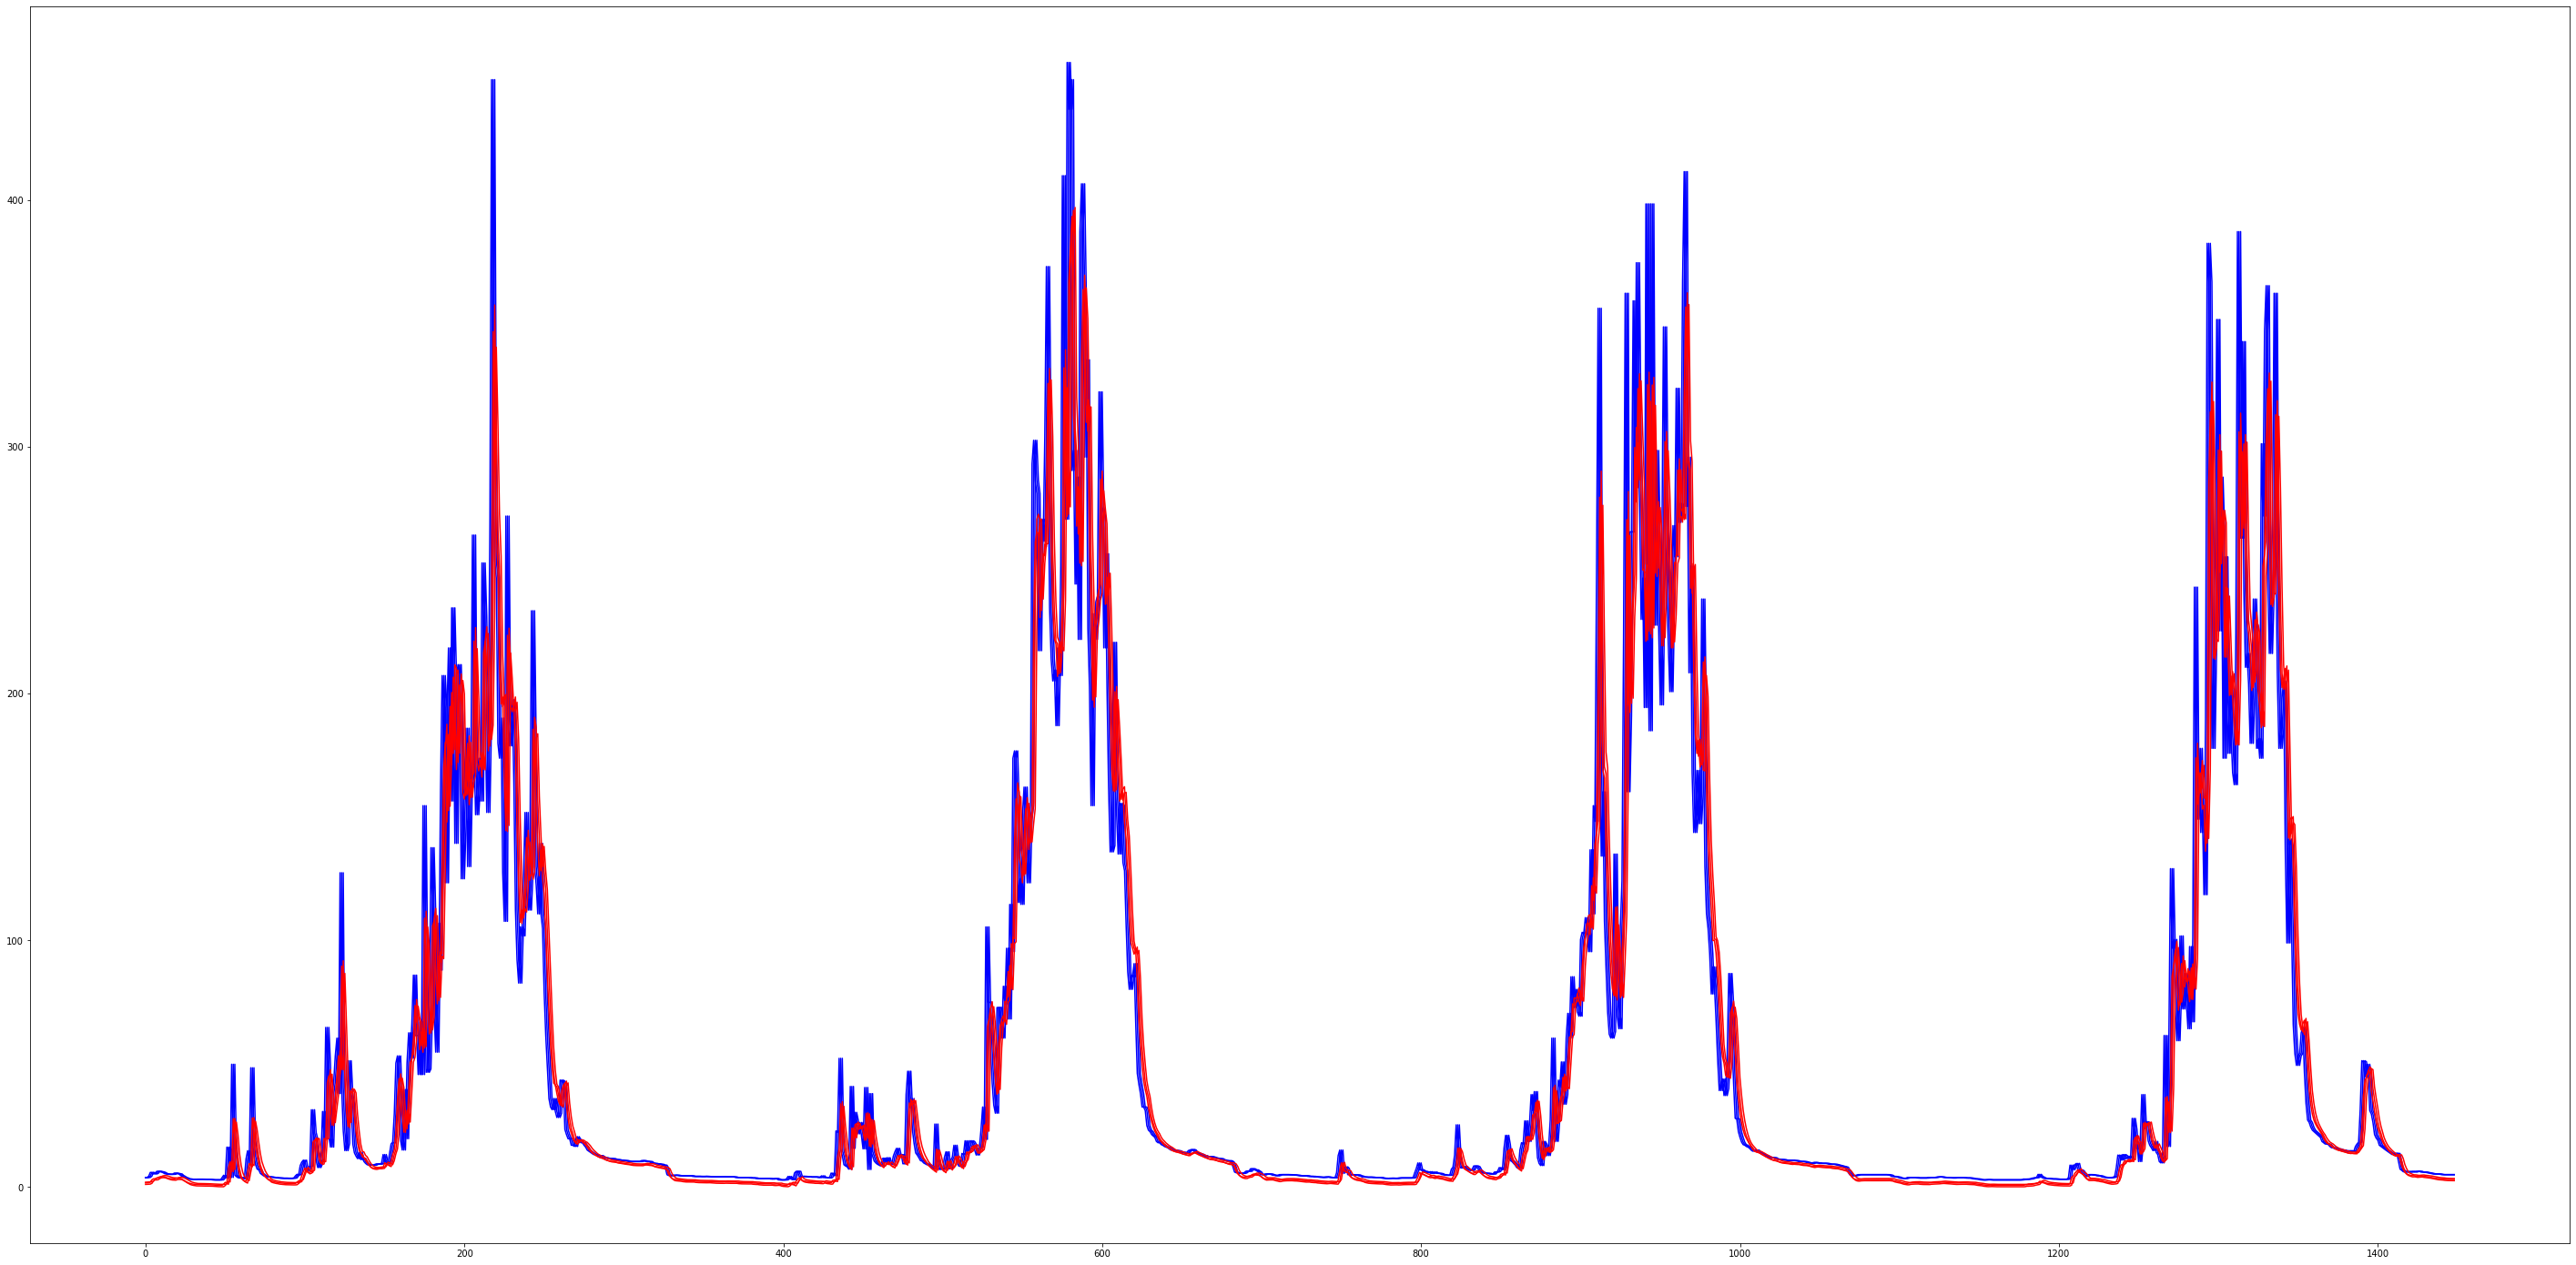

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

#2. In this section I have developed Encoder_decoder Model for univariate multi-step prediction task. Predicting 3 days in the future makes the sequence length of the decoder to be 3. Stacked LSTM/GRU cells are used both at Encoder and Decoder side of the network. In this encoder-decoder setting I have given a zero or -1 as input for the decoder with shape(samples,num-time-steps-out, output-features)

In [147]:
# The Encoder
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    #Stacked LSTM
    # encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))
    

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

encoder_states = encoder_outputs_and_states[1:]

In [148]:
# The decoder 
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    #Stacked LSTM
    # decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

decoder_outputs = decoder_outputs_and_states[0]

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

#It is realy confusing to undersatnd the difference between TimeDistributed(Dense(.....)) and Dense(....). They perform a similar task when we set the return_sequences=True. But when we set return_sequences=False there is no need to apply TimeDistributed(Dense()) since the LSTM network will have only output at the last decoder LSTM cell.

In [ ]:

decoder_dense = keras.layers.TimeDistributed(Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser))

#In the following cells an Encoder-Decoder impelementation using Bidirectional LSTM is demonstrated. The input to the decoder is zero/-1.

In [180]:
# The encoder
encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
#encoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
#encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

encoder_lstm2 = Bidirectional(LSTM(100,return_state=True))
#encoder_lstm2 = Bidirectional(GRU(100,return_state=True))
encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
#encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)

# state_h = Concatenate()([forward_h2,backward_h2])
# state_c = Concatenate()([forward_c2,backward_c2])
#encoder_states = [state_h, state_c]

states = [forward_h2,forward_c2,backward_h2,backward_c2]
#states = [forward_h2,backward_h2]



#The Decoder part 
decoder_inputs = keras.layers.Input(shape=(None, 1))


decoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
#decoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
decoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = decoder_lstm1(decoder_inputs,initial_state=states)
#decoder_lstm1_output,forward_h1,backward_h1 = decoder_lstm1(decoder_inputs,initial_state=states)

#decoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
#decoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
#decoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = decoder_lstm2(decoder_lstm1_output)
#decoder_lstm2_output,forward_h2,backward_h2 = decoder_lstm2(decoder_lstm1_output)

decoder_outputs = decoder_lstm1_output

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                  activation='linear',
                                  kernel_regularizer=regulariser,
                                  bias_regularizer=regulariser)


decoder_outputs = decoder_dense(decoder_outputs)


#These are the decoder input values which are set as zero. Since the decoder has sequence length of 3 and the output feature is only the streamflow data thus the the output feature size is one. Thus the shape of the decoder input will be (batchsize, 3,1). But zero is the not a correct way to select an intial token for decoder input since zero is part of our training time series data. It is better to select some other value (for example -1) which is not found in our dataset.

In this part the decoder input values are set as -1

In [ ]:
train_decoder_input_data1 = np.ones((7293,  3, 1))

In [ ]:
train_decoder_input_data1= np.negative(train_decoder_input_data1)

In [ ]:
valid_decoder_input_data1 = np.ones((1449,  3, 1))

In [ ]:
valid_decoder_input_data1 = np.negative(valid_decoder_input_data1)

In [ ]:
test_decoder_input_data1 = np.ones((1449,  3, 1))

In [ ]:
test_decoder_input_data1 = np.negative(valid_decoder_input_data1)

In this part the decoder input values are set as 0

In [82]:
train_decoder_input_data2 = np.zeros((7293,  3, 1))

In [83]:
valid_decoder_input_data2 = np.zeros((1449,  3, 1))

In [84]:
test_decoder_input_data2 = np.zeros((1449,  3, 1))

# Training the Model

In [181]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
#model.summary()
model.compile(optimizer=optimiser, loss=loss)

In [182]:
history2 = model.fit([train_X2,train_decoder_input_data2], train_y2, epochs=50, batch_size=100, validation_data=([val_X2,valid_decoder_input_data2], val_y2), verbose=1, shuffle=False)

Epoch 1/50
73/73 [==============================] - 11s 39ms/step - loss: 0.0064 - val_loss: 0.0011
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 9.6051e-04
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 9.5316e-04
Epoch 5/50
73/73 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 9.2893e-04
Epoch 6/50
73/73 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 9.2283e-04
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 9.1998e-04
Epoch 8/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 9.1954e-04
Epoch 9/50
73/73 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 9.3089e-04
Epoch 10/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019

#Plotting the loss curve

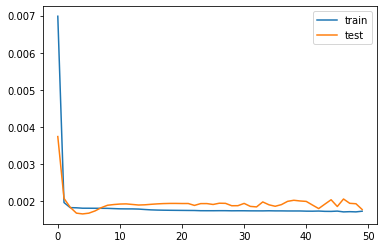

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction result on the test set data

In [183]:
y_test_predicted = model.predict([test_X2,test_decoder_input_data2])
pred= tf.reshape(y_test_predicted, [1449, 3])
orig=tf.reshape(test_y2, [1449, 3])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE, MAE and NSE value of the model for the different time steps and for aggregate as well

In [184]:
score, scores = evaluate_forecasts_mse(inv_y2, inv_yhat2)
score, scores

(32.51, [27.97, 33.43, 35.64])

In [185]:
score, scores = evaluate_forecasts_mae(inv_y2, inv_yhat2)
score, scores

(15.94, [12.54, 16.47, 18.81])

In [186]:
score, scores = evaluate_forecasts_nse(inv_y2, inv_yhat2)
score, scores

(0.86, [0.90, 0.85, 0.83])

#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.70600926827314  versus inv_yhat2 (SIM) max: 346.5944193641161


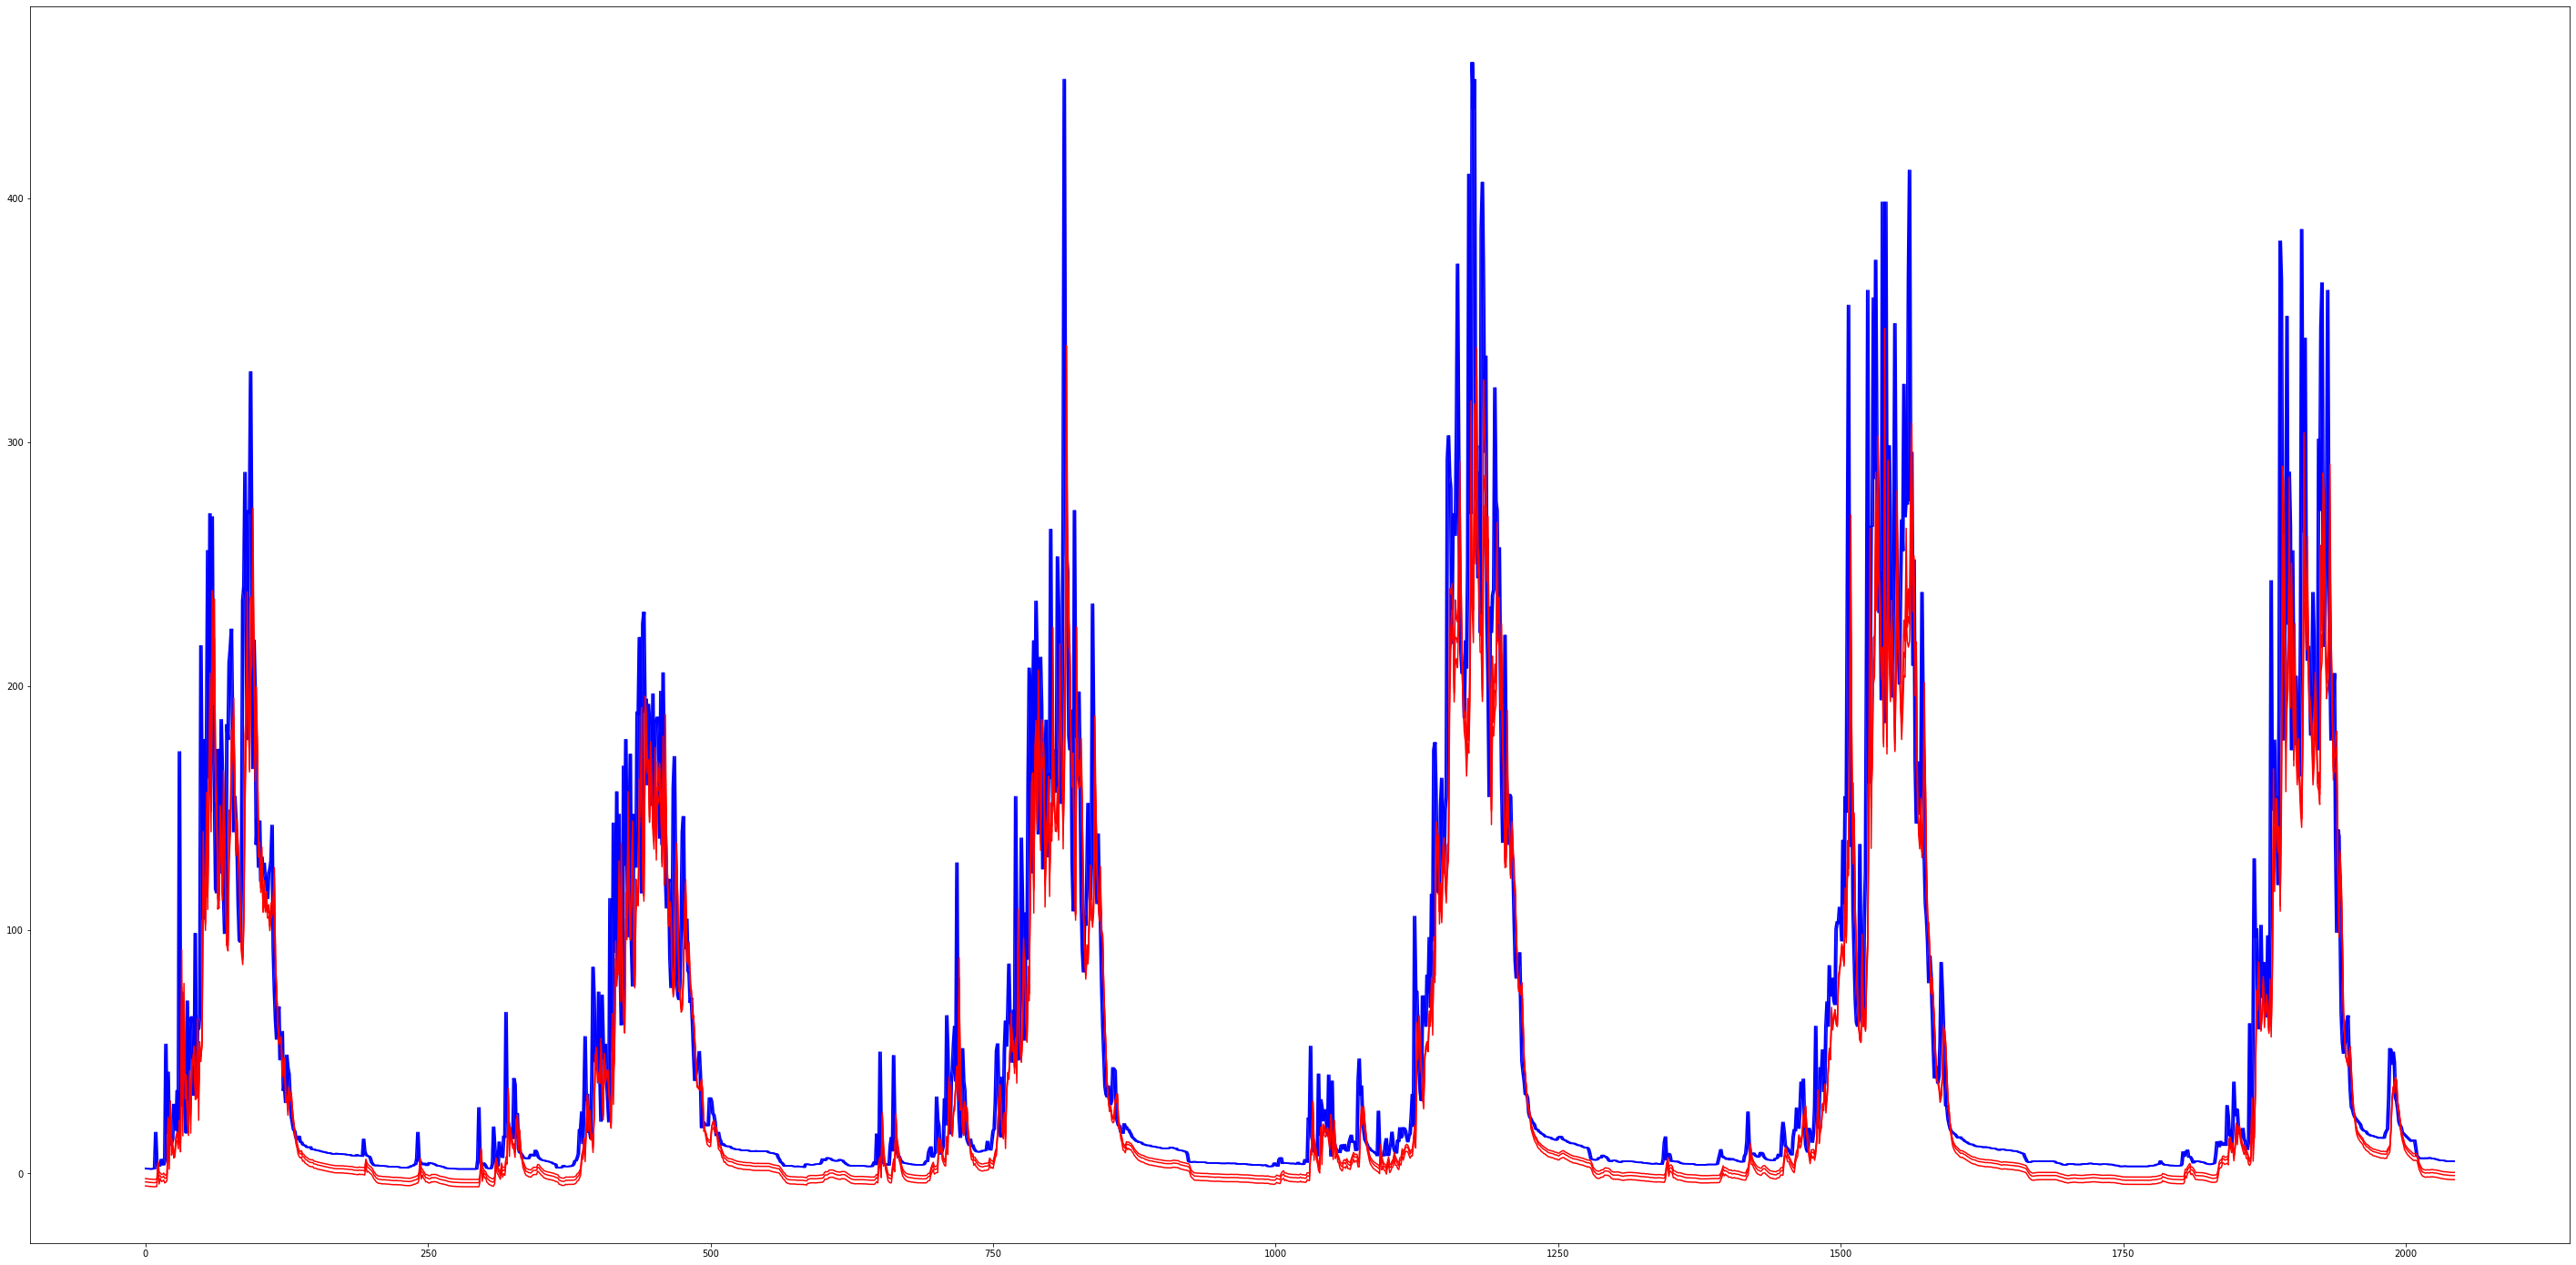

In [ ]:

print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

#3. In this part an encoder-decoder model for univariate multi step output is developed where the decoder initial token will be the last encoder output. The input for the next time steps of the decoder will be the previous decoder output. Using Single layer LSTM/GRU and stacked (2 layer) LSTM/GRU cells.

In [34]:
def _create_stacked_rnn_cells():
    """
   Create a `layers_stacked_count` amount of GRU cells and stack them on top of each other.
   They have a `hidden_dim` number of neuron layer size.

   :param step: The base Neuraxle step for TensorFlow v2 (Tensorflow2ModelStep)
    :return: list of gru cells
    """
    cells = []
    for _ in range(2): # modifiy this one
        cells.append(GRUCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
        #cells.append(LSTMCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
    
    return cells

In [35]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')
  encoder_lstm = RNN(cell=_create_stacked_rnn_cells(),  return_state=True)
  #encoder_lstm = LSTM(100, return_state=True,  name='encoder_lstm')
  #encoder_lstm = GRU(100, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)  # for single layer LSTM and RNN cells (both LSTM and GRU)
  #encoder_outputs, state_h = encoder_lstm(encoder_inputs) # for single layer GRU

  encoder_output_densed = Dense(num_input_features,  name='encoder_dense')(encoder_outputs)
    
  decoder_input_data = tf.expand_dims(encoder_output_densed, axis=1)

  states = [state_h, state_c]    # for single layer LSTM and RNN cells (both LSTM and GRU)
  #states = [state_h]            #for single layer GRU
 
  # The decoder part
  decoder_inputs = Input(shape=(1, num_input_features))
  
  decoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=True, return_state=True)
  #decoder_lstm = LSTM(100, return_sequences=True, return_state=True, name='decoder_lstm')
  #decoder_lstm = GRU(100, return_sequences=True, return_state=True, name='decoder_lstm')
  
  decoder_dense = Dense(num_input_features,  name='decoder_dense')
  
  all_outputs = []

  inputs = decoder_input_data

  sequence_length = 3
  for _ in range(sequence_length):
      
      outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states) # for single layer STM and RNN cells (both LSTM and GRU)
      #outputs, state_h = decoder_lstm(inputs, initial_state=states)       # for single layer GRU
      
      dropout = Dropout(rate=0.25)
      outputs = dropout(outputs)
      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)

      inputs = outputs
      states = [state_h, state_c]    # for single layer STM and RNN cells (both LSTM and GRU)
      #states = [state_h]    # for single layer GRU
      
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model

#In the following cells an Encoder-Decoder impelementation using Bidirectional LSTM/GRU is demonstrated. The input to the decoder is last encoder output after being densed.

In [77]:
def create_hard_coded_decoder_input_model2(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

  encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
  #encoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
  encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
  #encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

  encoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=False))
  #encoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=False))
  encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
  #encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)

  encoder_output_densed = Dense(num_input_features,  name='encoder_dense')(encoder_lstm2_output)
  

  decoder_input_data = tf.expand_dims(encoder_output_densed, axis=1)
  print(decoder_input_data)
  states = [forward_h2,forward_c2,backward_h2,backward_c2]
  #states = [forward_h2,backward_h2]

  #The Decoder part 
  decoder_inputs=Input(shape=(1, num_input_features), name='encoder_inputs')


  #decoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
  decoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))


  decoder_dense = Dense(num_output_features, activation='linear',  kernel_regularizer=regulariser, bias_regularizer=regulariser, name='decoder_dense')

  all_outputs = []
  inputs = decoder_input_data

  sequence_length = 3
  for _ in range(sequence_length):
      
      #outputs, forward_state_h, backward_state_h = decoder_lstm1(inputs, initial_state=states)
      outputs, forward_h,forward_c,backward_h,backward_c = decoder_lstm1(inputs, initial_state=states)
      
      # dropout = Dropout(rate=0.25)
      # outputs = dropout(outputs)

      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)
      inputs = outputs
      #states = [forward_state_h, backward_state_h]
      states = [forward_h,forward_c,backward_h,backward_c]
      

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model


#Training the Model

In [78]:
model_encoder_decoder=create_hard_coded_decoder_input_model2(batch_size=batch_size)
#model_encoder_decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='tf.expand_dims_7/ExpandDims:0', description="created by layer 'tf.expand_dims_7'")


In [79]:
history2 = model_encoder_decoder.fit(train_X2, train_y2, epochs=50, batch_size=100, validation_data=(val_X2, val_y2), verbose=1, shuffle=False)

Epoch 1/50
73/73 [==============================] - 16s 60ms/step - loss: 0.0048 - accuracy: 2.7424e-04 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 2/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0026 - accuracy: 2.7424e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 4/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/50
73/73 [==============================] - 2s 22ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0018 - accuracy: 2.7424e-04 - 

#Plotting the loss curve

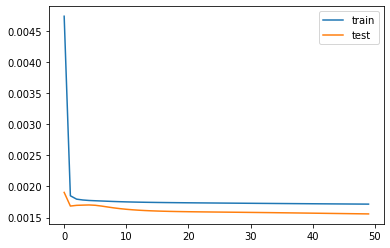

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction result on test dataset

In [80]:
y_test_predicted = model_encoder_decoder.predict(test_X2)
pred= tf.reshape(y_test_predicted, [1449, 3])
orig=tf.reshape(test_y2, [1449, 3])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE, MAE and NSE value of the model for the different time steps and for aggregate as well

In [45]:
%precision %.2f

'%.2f'

In [81]:
score, scores = evaluate_forecasts_mse(inv_y2, inv_yhat2)
score, scores

(32.55, [27.87, 33.48, 35.78])

In [82]:
score, scores = evaluate_forecasts_mae(inv_y2, inv_yhat2)
score, scores

(14.50, [12.11, 15.06, 16.33])

In [83]:
score, scores = evaluate_forecasts_nse(inv_y2, inv_yhat2)
score, scores

(0.86, [0.90, 0.85, 0.83])

#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.70600926827314  versus inv_yhat2 (SIM) max: 347.3748123026958


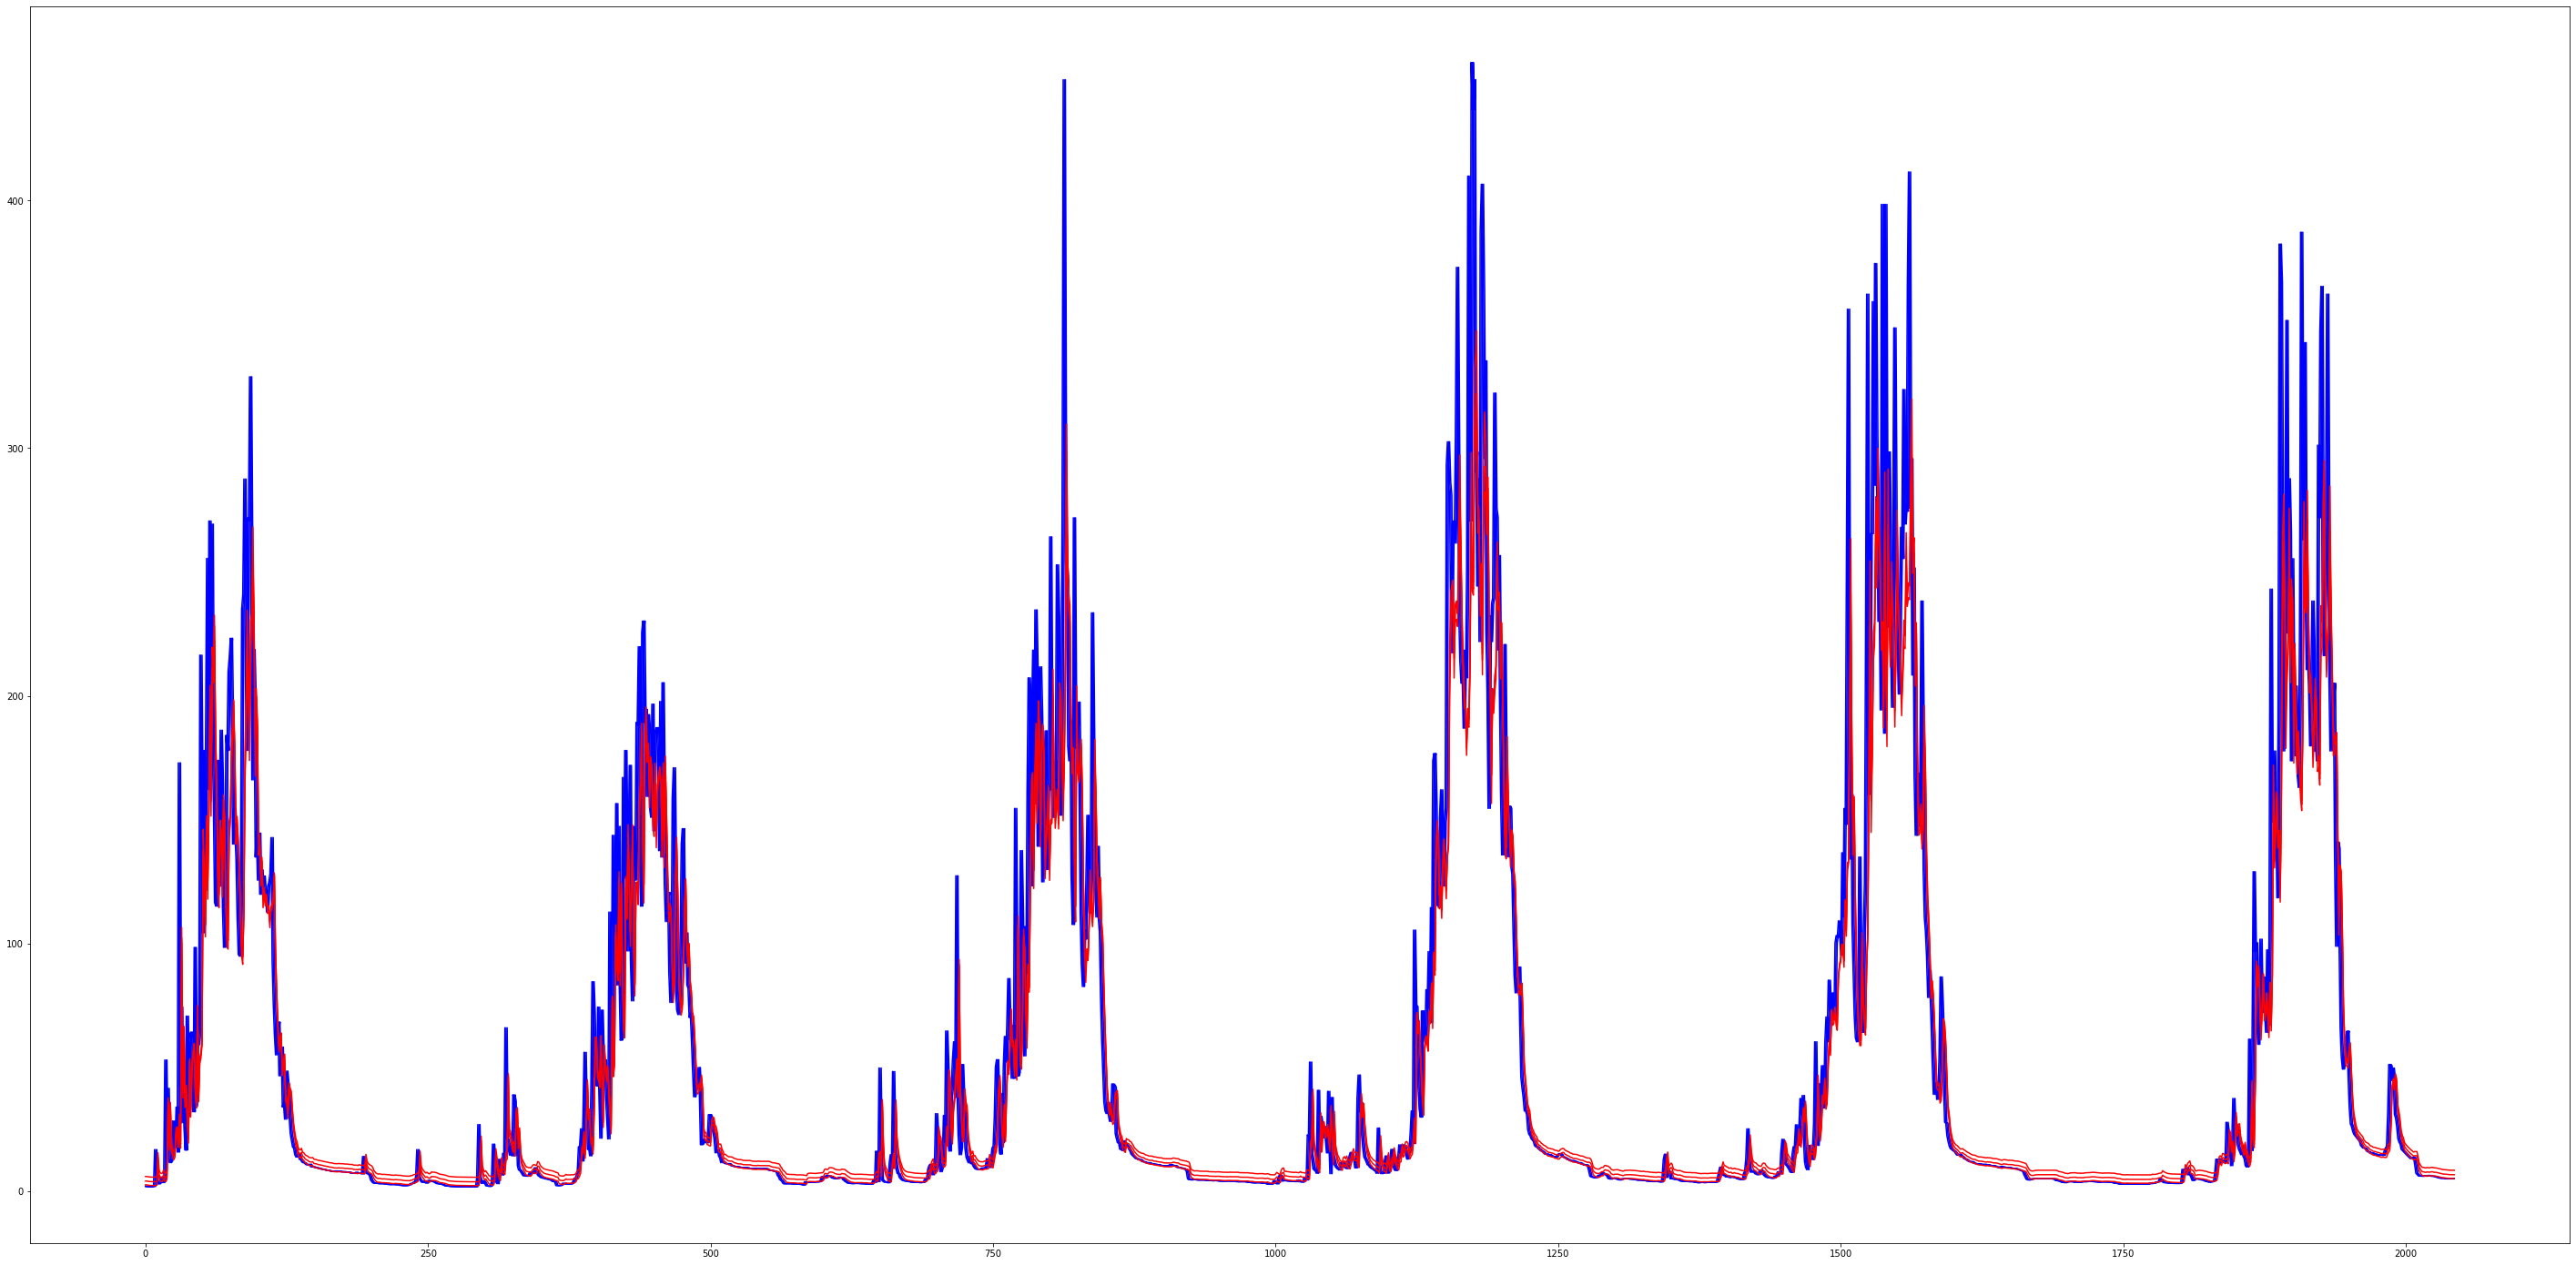

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

#4. In this part an encoder-decoder model is developed where the decoder input at alltime steps of the decoder will be the last encoder output without being fed to a dense layer. The encoder output is Repeated based on the number of decoder output sequence length. Then the repeated encoder output will be fed as an input to the decoder at each time step.

In [111]:
def _create_stacked_rnn_cells():
    """
   Create a `layers_stacked_count` amount of GRU cells and stack them on top of each other.
   They have a `hidden_dim` number of neuron layer size.

   :param step: The base Neuraxle step for TensorFlow v2 (Tensorflow2ModelStep)
    :return: list of gru cells
    """
    cells = []
    for _ in range(2): # modifiy this one
        #cells.append(GRUCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
        cells.append(LSTMCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
    
    return cells

In [119]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')
  encoder_lstm = RNN(cell=_create_stacked_rnn_cells(),  return_state=True)
  #encoder_lstm = LSTM(100, return_state=True,  name='encoder_lstm')
  #encoder_lstm = GRU(100, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)  # for single layer LSTM and RNN cells (both LSTM and GRU)
  #encoder_outputs, state_h = encoder_lstm(encoder_inputs) # for single layer GRU


  last_encoder_output = tf.expand_dims(encoder_outputs, axis=1)
 
  replicated_last_encoder_output = tf.repeat(
        input=last_encoder_output,
        repeats=3, # This value will be changed based on the size of the decoder output sequence length
        axis=1
    )

  states = [state_h, state_c]    # for single layer LSTM and RNN cells (both LSTM and GRU)
  #states = [state_h]            #for single layer GRU
 
  # The decoder part
  decoder_inputs = Input(shape=(1, num_input_features))
  
  decoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=True, return_state=True)
  #decoder_lstm = LSTM(100, return_sequences=True, return_state=True, name='decoder_lstm')
  #decoder_lstm = GRU(100, return_sequences=True, return_state=True, name='decoder_lstm')

  outputs, state_h, state_c = decoder_lstm(replicated_last_encoder_output, initial_state=states) # for single layer STM and RNN cells (both LSTM and GRU)
  #outputs, state_h = decoder_lstm(inputs, initial_state=states)       # for single layer GRU
  
  decoder_dense = Dense(num_input_features,  name='decoder_dense')

  # dropout = Dropout(rate=0.25)
  # outputs = dropout(outputs)

  decoder_outputs = decoder_dense(outputs)
  

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model

#Using Bi_LSTM/GRU

In [147]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

  #encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
  encoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
  #encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
  encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

  #encoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=False))
  encoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=False))
  #encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
  encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)


  last_encoder_output = tf.expand_dims(encoder_lstm2_output, axis=1)
  
  replicated_last_encoder_output = tf.repeat(
        input=last_encoder_output,
        repeats=3, # The number of repeatitions will be dependent on the decoder output sequence length
        axis=1
    )



  #states = [forward_h2,forward_c2,backward_h2,backward_c2]
  states = [forward_h2,backward_h2]

  #The Decoder part 
  decoder_inputs=Input(shape=(1, num_input_features), name='encoder_inputs')

  decoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
  #decoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))

  decoder_dense = Dense(num_output_features, activation='linear',  kernel_regularizer=regulariser, bias_regularizer=regulariser, name='decoder_dense')

  outputs, forward_state_h, backward_state_h = decoder_lstm1(replicated_last_encoder_output, initial_state=states)
  #outputs, forward_h,forward_c,backward_h,backward_c = decoder_lstm1(replicated_last_encoder_output, initial_state=states)

  
  # dropout = Dropout(rate=0.25)
  # outputs = dropout(outputs)

  decoder_outputs = decoder_dense(outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model


#Training the Model

In [148]:
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
#model_encoder_decoder.summary()

In [149]:
history2 = model_encoder_decoder.fit(train_X2, train_y2, epochs=50, batch_size=100, validation_data=(val_X2, val_y2), verbose=1, shuffle=False)

Epoch 1/50
73/73 [==============================] - 10s 36ms/step - loss: 0.0069 - accuracy: 2.7424e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 9.8189e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 9.5254e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 9.5096e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 9.2911e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 2.7424e-04 - val_loss: 9.1764e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0018 - acc

#Plotting the loss curve

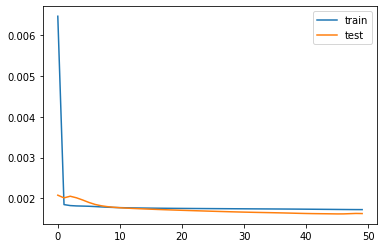

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction result on test dataset

In [150]:
y_test_predicted = model_encoder_decoder.predict(test_X2)
pred= tf.reshape(y_test_predicted, [1449, 3])
orig=tf.reshape(test_y2, [1449, 3])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE, MAE and NSE value of the model for the different time steps and for aggregate as well

In [151]:
score, scores = evaluate_forecasts_mse(inv_y2, inv_yhat2)
score, scores

(32.35, [27.73, 33.22, 35.60])

In [152]:
score, scores = evaluate_forecasts_mae(inv_y2, inv_yhat2)
score, scores

(15.06, [13.06, 15.37, 16.74])

In [153]:
score, scores = evaluate_forecasts_nse(inv_y2, inv_yhat2)
score, scores

(0.86, [0.90, 0.85, 0.83])

#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.70600926827314  versus inv_yhat2 (SIM) max: 332.07375872944397


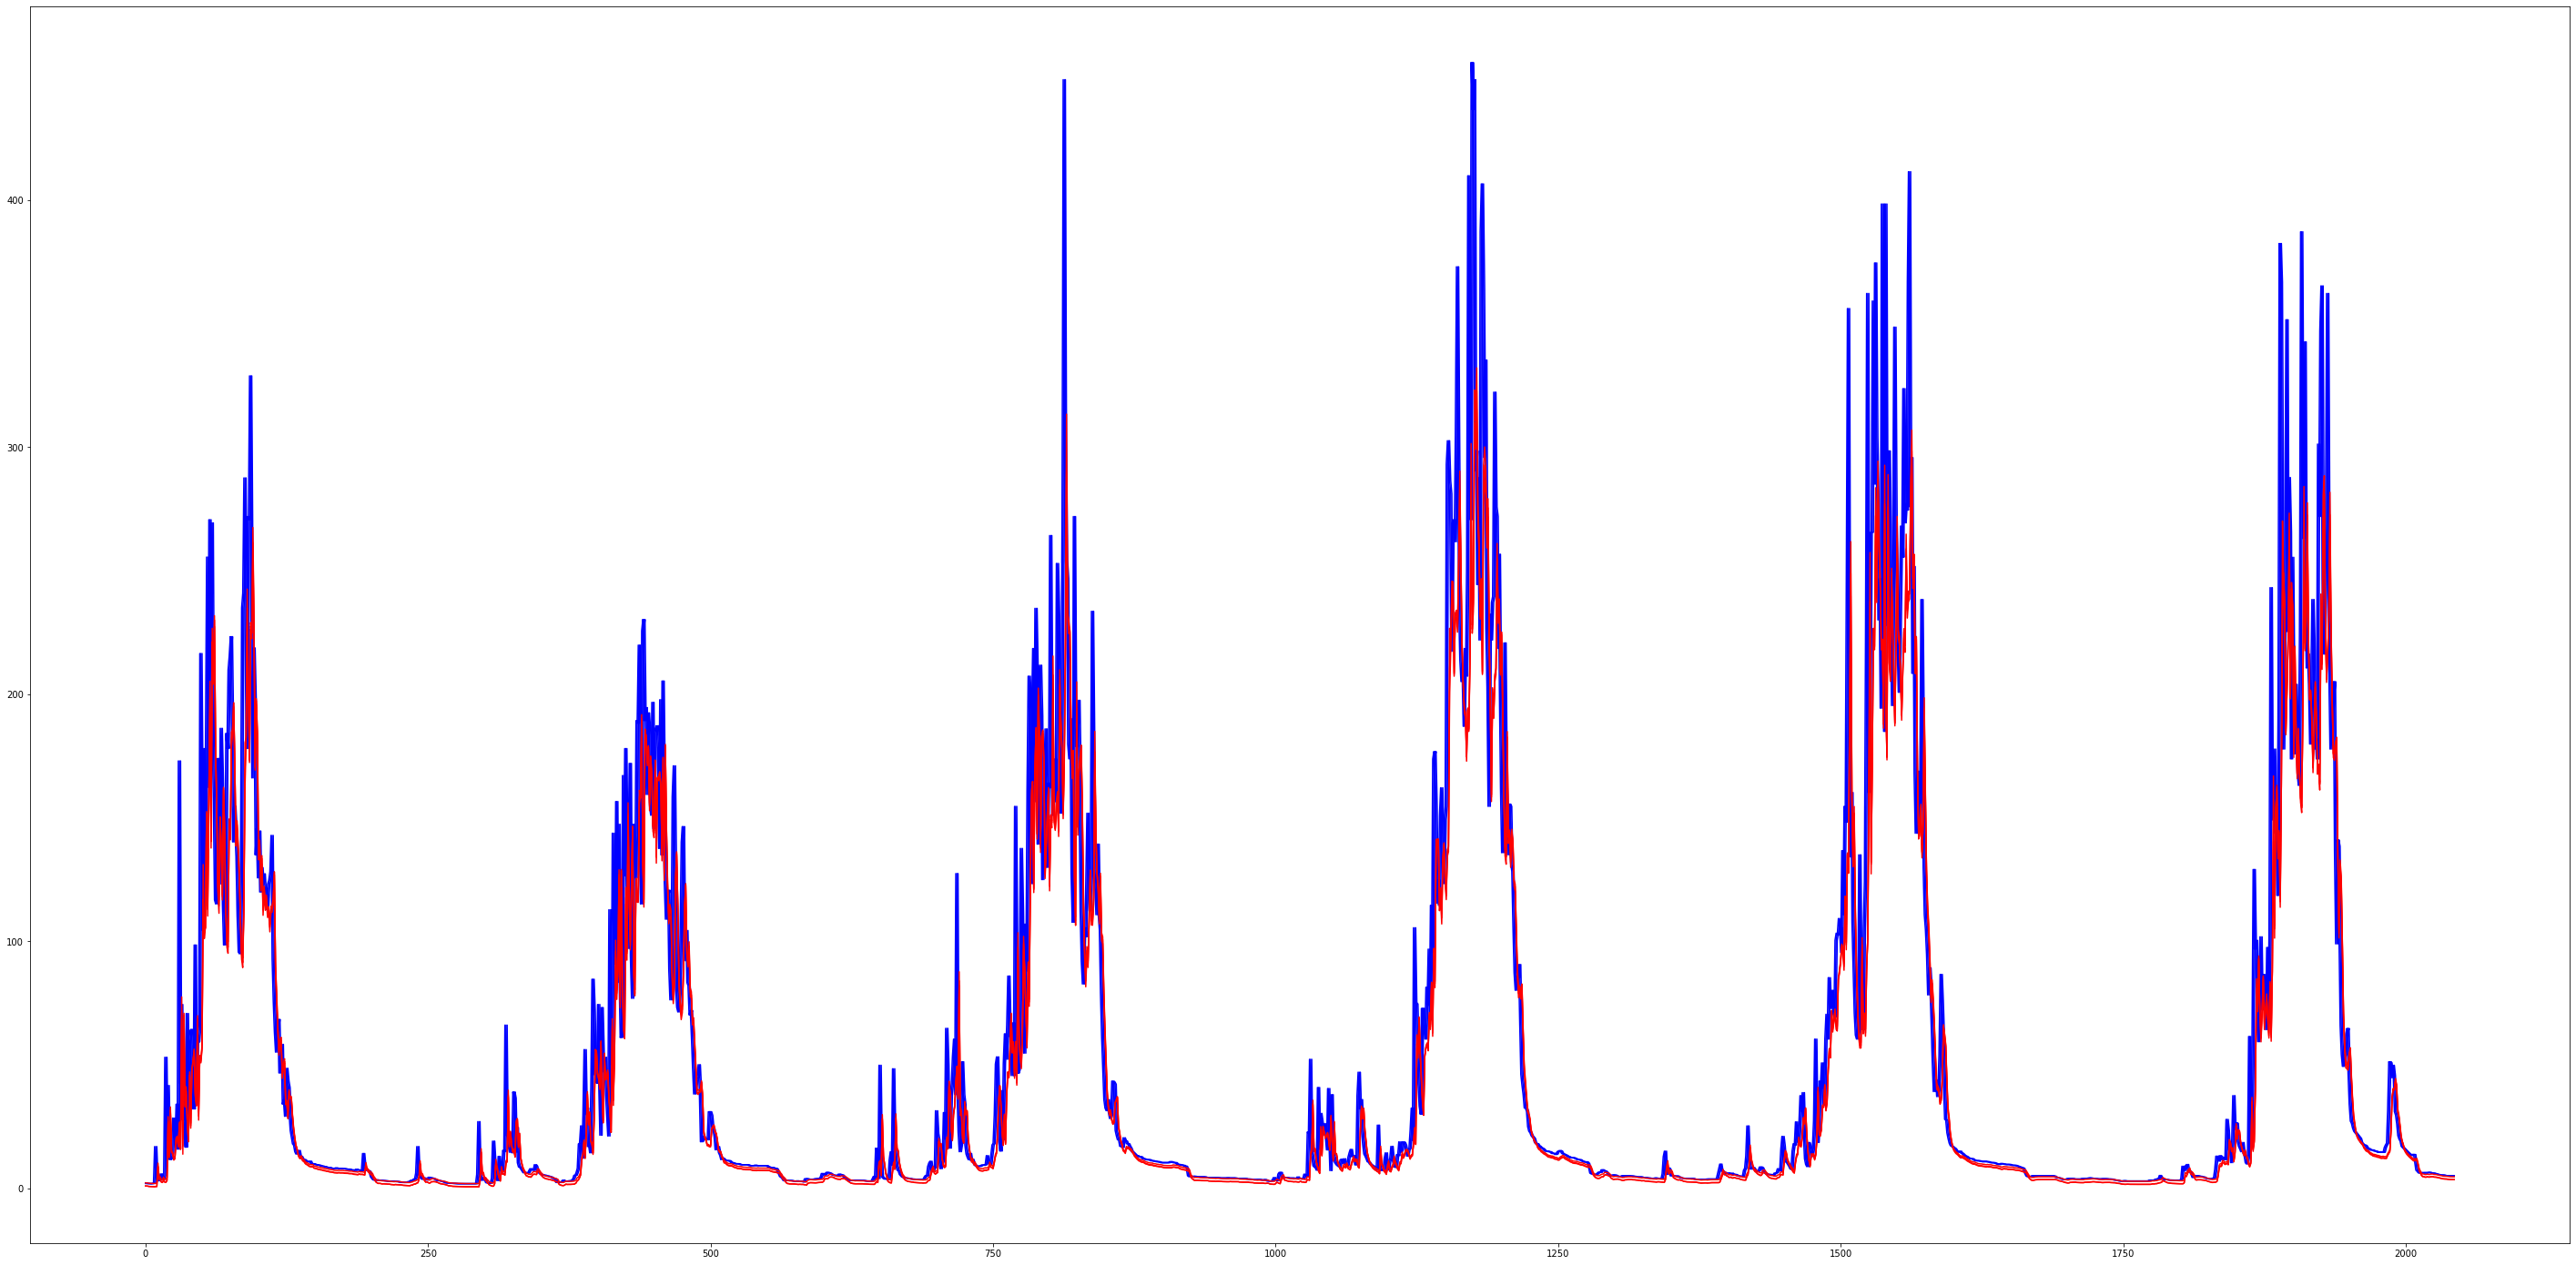

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()